# **Prediction of overall survival in patients with Myeloid Leukemia**

## **Challenge description**

**A- Goal**

The goal of this challenge organized by QRT and Institut Gustave Roussy - 2025, is to **predict accurately survival for patients diagnosed with blood cancer, specifically within subtypes of adult myeloid leukemias.** Overall survival is described by the period between the initial diagnosis to either the patient’s death or the lost to follow-up.\
Accurate risk predictions could lead to better clinical decision-making, improved patient outcomes, and more efficient resource allocation within healthcare facilities.

**B- Data Overview**

We get two sets of data:
  - **training set with 3323 patients** which will be used to set our model (feature management and engineering, hyperparameters tuning and learning)
  - **test set with 1193 patients** for which we will predict the risk score using their features.

There are two types of features:
  - **clinical features (one row per patient)** including the clinical center, bone marrow blasts percentage, WBC count, ANC count, monocytes count, HB level, platelet count and cytogenetics.
  - **Gene molecular features (one row per somatic mutation per patient)**. Somatic (acquired) mutations are mutations specific to cancerous cells, not found in the patient’s normal cells.

The outcomes provided in Y_train set are the overall survival time in years from diagnosis (OS_YEARS) and the censoring indicator (OS_STATUS) denoting death or alive or lost to FUP of each patient in training set. Then **the expected output will be the predicted risk of death (risk score) for each patient in test set**.

**C- Metric**

**The loss metric is the Concordance Index for Right-Censored Data with IPCW (IPCW-C-index)**. This metric is an extension of classical c-index used to measures how well a predictive model can correctly rank survival times. This extension apply inverse probability of censoring weights (IPCW) depending on censored data to better handle right-censored data. \
This metric as well as classical c-index are implemented in scikit-survival python package.

**D- Benchmark**

The first benchmark (LGBM model) is provided as an example. The actual score obtained with the second benchmark (Cox model) is equal to **0.6541** and is the one expected to exceed.

## **Packages and data loading**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
#@title Set options and import librairies
import sys
sys.path.append('/content/drive/MyDrive/colab_libs')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import gc
gc.collect()

import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import re

#import miceforest as mf
import scipy
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder, PowerTransformer, QuantileTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import plot_tree
from sklearn.cluster import KMeans
from sklearn.metrics import make_scorer

import sksurv
import lifelines
from sksurv.util import Surv
from sksurv.ensemble import RandomSurvivalForest, GradientBoostingSurvivalAnalysis, ExtraSurvivalTrees
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored , concordance_index_ipcw
import xgboost as xgb

import joblib

os.chdir("/content/drive/MyDrive/Challenges/QRT")

In [ ]:
#@title Import data
# Clinical data
clin_train_df=pd.read_csv("./X_train/clinical_train.csv")
clin_test_df=pd.read_csv("./X_test/clinical_test.csv")

# Molecular data
mol_train_df=pd.read_csv("./X_train/molecular_train.csv")
mol_test_df=pd.read_csv("./X_test/molecular_test.csv")

# Y train (OS YEAR and STATUS)
y_train=pd.read_csv("./target_train.csv")

In [ ]:
# @title Check imported data
clin_train_df.head()
mol_train_df.head()
y_train.head()

clin_train_df.info()
mol_train_df.info()
y_train.info()

## **Exploratory analysis**

### Target y_train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3323 entries, 0 to 3322
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         3323 non-null   object 
 1   OS_YEARS   3173 non-null   float64
 2   OS_STATUS  3173 non-null   float64
dtypes: float64(2), object(1)
memory usage: 78.0+ KB


,OS_YEARS,OS_STATUS
count,3173.000000,3173.000000
mean,2.480713,0.504255
std,2.588259,0.500061
min,0.000000,0.000000
25%,0.652055,0.000000
50%,1.652055,1.000000
75%,3.572603,1.000000
max,22.043836,1.000000


,count
OS_STATUS,
1.0,1600
0.0,1573


<Axes: xlabel='OS_STATUS', ylabel='OS_YEARS'>

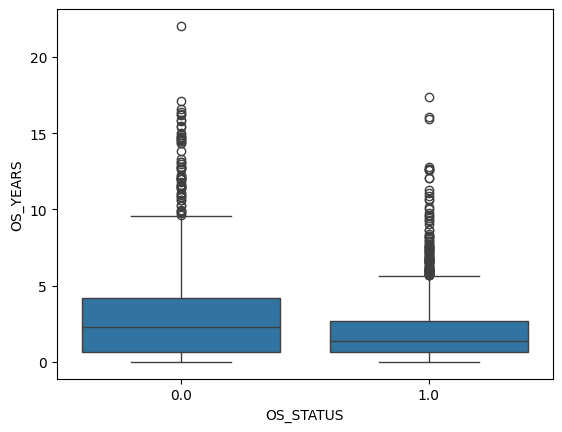

In [ ]:
#@title Survival object description : Duration and censoring status
y_train.info()
y_train.describe()
y_train["OS_STATUS"].value_counts()
sns.boxplot(y_train, x="OS_STATUS", y="OS_YEARS")
plt.show()
# @markdown Outliers identified in OS_YEARS and then asymetric distribution. \
# @markdown But since this is survival duration, I won't standardize it just use logarithimic scale in analysis to reduce extreme values impact.
# @markdown There are some missing data. I delete them and also delete these patients in features set

In [ ]:
#@title Patients to keep in analysis
y_train.dropna(how="any", inplace=True)
y_train.reset_index(drop=True, inplace=True)
id_to_keep=y_train["ID"].unique().tolist()

### Clinical data

In [ ]:
#@title Info
clin_train_df.info()
clin_train_df.head()
clin_train_df=clin_train_df[clin_train_df["ID"].isin(id_to_keep)].reset_index(drop=True)
clin_train_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3323 entries, 0 to 3322
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            3323 non-null   object 
 1   CENTER        3323 non-null   object 
 2   BM_BLAST      3214 non-null   float64
 3   WBC           3051 non-null   float64
 4   ANC           3130 non-null   float64
 5   MONOCYTES     2722 non-null   float64
 6   HB            3213 non-null   float64
 7   PLT           3199 non-null   float64
 8   CYTOGENETICS  2936 non-null   object 
dtypes: float64(6), object(3)
memory usage: 233.8+ KB


,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,P132697,MSK,14.0,2.8,0.2,0.7,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]"
1,P132698,MSK,1.0,7.4,2.4,0.1,11.6,42.0,"46,xx"
2,P116889,MSK,15.0,3.7,2.1,0.1,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]"
3,P132699,MSK,1.0,3.9,1.9,0.1,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]"
4,P132700,MSK,6.0,128.0,9.7,0.9,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]"


,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,CYTOGENETICS
0,P132697,MSK,14.0,2.80,0.20,0.70,7.6,119.0,"46,xy,del(20)(q12)[2]/46,xy[18]"
1,P132698,MSK,1.0,7.40,2.40,0.10,11.6,42.0,"46,xx"
2,P116889,MSK,15.0,3.70,2.10,0.10,14.2,81.0,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]"
3,P132699,MSK,1.0,3.90,1.90,0.10,8.9,77.0,"46,xy,del(3)(q26q27)[15]/46,xy[5]"
4,P132700,MSK,6.0,128.00,9.70,0.90,11.1,195.0,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]"
...,...,...,...,...,...,...,...,...,...
3168,P121826,VU,1.0,2.50,1.02,0.20,10.2,78.0,"47~49,xy,+21,+21,+22[cp11]/46,xy[10]"
3169,P121827,VU,1.5,8.10,2.66,0.45,11.3,40.0,"44,xx,inv(2)(p25q31),-4,del(5)(q12q33),-18[20]"
3170,P121830,VU,0.0,1.80,0.55,0.29,9.4,86.0,"46,xy,del(20)(q11.2q13.1)[4]/45,xy,idem,-7[16]"
3171,P121853,VU,5.0,1.37,0.37,0.11,11.4,102.0,"46,xx,del(1)(p34)[5]/45,xx,sl,-18[12]/46,xx,sd..."


In [ ]:
#@title Overview and description of float variables
clin_train_df.info()
clin_train_df.select_dtypes("float").describe()
missing_values = clin_train_df.isnull().sum()
print(missing_values[missing_values > 0])
#@markdown Results below shows that monocytes variables have more missing data (around 601 or 18% of missing data). Either I will impute this data or I will remove missing lines or
#@markdown exclude it from analysis. For variables BM_BLAST, WBC, ANC, HB and PLT, I will either imput missing data or remove missing lines.
#@markdown With this result I suspect presence of outliers and asymetric data.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173 entries, 0 to 3172
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            3173 non-null   object 
 1   CENTER        3173 non-null   object 
 2   BM_BLAST      3094 non-null   float64
 3   WBC           2944 non-null   float64
 4   ANC           3032 non-null   float64
 5   MONOCYTES     2629 non-null   float64
 6   HB            3098 non-null   float64
 7   PLT           3087 non-null   float64
 8   CYTOGENETICS  2825 non-null   object 
dtypes: float64(6), object(3)
memory usage: 223.2+ KB


,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT
count,3094.000000,2944.000000,3032.000000,2629.000000,3098.000000,3087.000000
mean,6.071041,6.597417,3.286438,0.971848,9.861709,167.070758
std,7.662941,10.405641,5.308014,2.710523,2.030977,150.234265
min,0.000000,0.200000,0.000000,0.000000,4.000000,2.000000
25%,1.000000,2.700000,1.000000,0.149000,8.500000,65.000000
50%,3.000000,4.100000,2.000000,0.370000,9.700000,123.000000
75%,8.000000,6.700000,3.700000,0.792000,11.100000,229.500000
max,91.000000,154.400000,109.620000,44.200000,16.600000,1451.000000


BM_BLAST         79
WBC             229
ANC             141
MONOCYTES       544
HB               75
PLT              86
CYTOGENETICS    348
dtype: int64


<Axes: ylabel='BM_BLAST'>

Text(0.5, 1.0, 'Boxplot of BM_BLAST')

<Axes: ylabel='WBC'>

Text(0.5, 1.0, 'Boxplot of WBC')

<Axes: ylabel='ANC'>

Text(0.5, 1.0, 'Boxplot of ANC')

<Axes: ylabel='MONOCYTES'>

Text(0.5, 1.0, 'Boxplot of MONOCYTES')

<Axes: ylabel='HB'>

Text(0.5, 1.0, 'Boxplot of HB')

<Axes: ylabel='PLT'>

Text(0.5, 1.0, 'Boxplot of PLT')

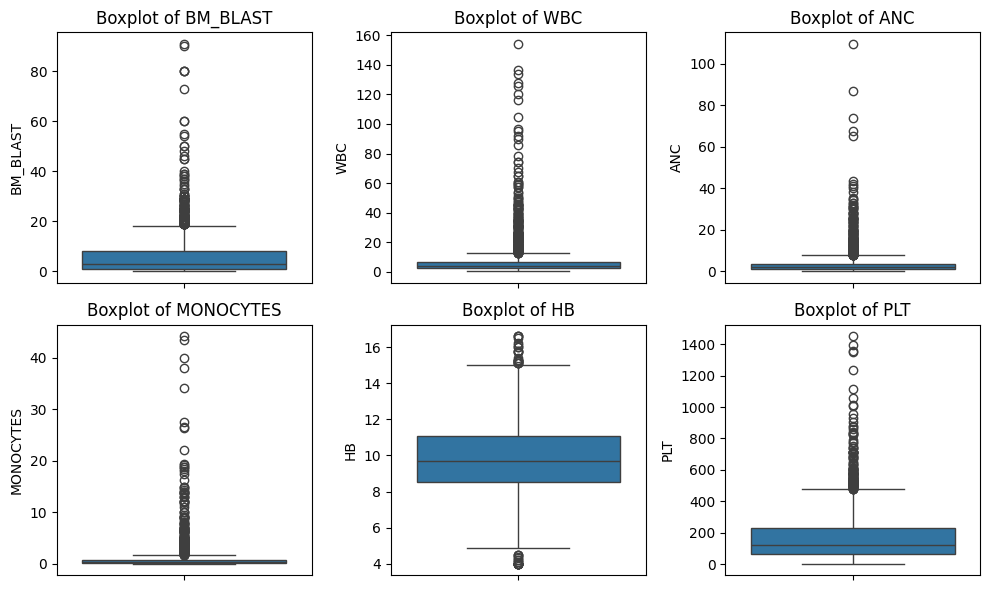

In [ ]:
#@title Box plots of float variables to identify outliers
float_col=clin_train_df.select_dtypes("float").columns
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
axes = axes.flatten()
for i, col in enumerate(float_col):
  sns.boxplot(clin_train_df, y=col, ax=axes[i])
  axes[i].set_title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()
#@markdown This figure suggers that variables have many outliers and then asymetric distribution and high dispersion. Also PLT is not in the same scale as the the others variables.
# So in next step, I will need to detect and handle these outliers, transform variables in log scale or in using box-cox, and standardize these features

,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT
BM_BLAST,1.000000,-0.184223,-0.250685,-0.120421,-0.040173,-0.318050
WBC,-0.184223,1.000000,0.897488,0.654380,0.082185,0.235459
ANC,-0.250685,0.897488,1.000000,0.526565,0.049782,0.266956
MONOCYTES,-0.120421,0.654380,0.526565,1.000000,0.163196,0.143235
HB,-0.040173,0.082185,0.049782,0.163196,1.000000,-0.006564
PLT,-0.318050,0.235459,0.266956,0.143235,-0.006564,1.000000


[('WBC', 'ANC'), ('WBC', 'MONOCYTES'), ('ANC', 'WBC'), ('MONOCYTES', 'WBC')]

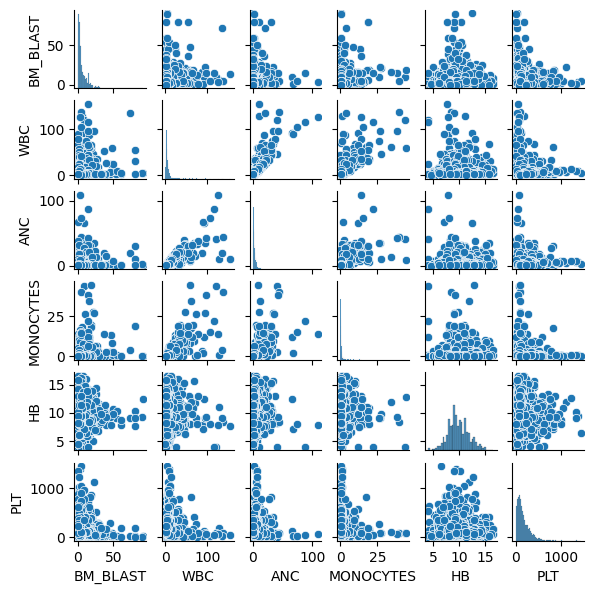

In [ ]:
# @title Analysis of correlation between variables
## @title Spearman corr
cor=clin_train_df.select_dtypes("float").corr("spearman")
cor
corr_perfect = [(var1, var2) for var1 in cor.columns
                for var2 in cor.columns
                if var1 != var2 and abs(cor.loc[var1, var2]) > 0.6]
corr_perfect
## @title Pairplot
float_col=clin_train_df.select_dtypes("float").columns
sns.pairplot(clin_train_df[float_col], kind='scatter', height=1)
plt.show()
#@markdown Results shows higher correlation between ANC and WBC. \
#@markdown Also correlation between Monocytes and WBC and ANC is quiet higher(respectively 0.65 and 0.52).\
#@markdown Then I will either keep only ANC or WBC or extract a significant features from Monocytes, ANC and WBC\
#@markdown Since Monocytes have higher number of missing data and correlated with ANC and WBC, I will surely remove this variable from analysis.

In [ ]:
# @title Analysis of correlation between OS_STATUS and features
features=clin_train_df.select_dtypes("float")
status=y_train["OS_STATUS"]
corxy=features.corrwith(status, method="spearman").sort_values(ascending=False)
corxy
# @markdown No higher correlation with status death or not.

,0
BM_BLAST,0.236147
WBC,-0.029320
ANC,-0.038272
MONOCYTES,-0.056677
PLT,-0.166087
HB,-0.174230


In [ ]:
# @title Analysis of cytogenetics
# @markdown Detailed description of the patient's karyotype, representing chromosomal abnormalities detected in blood cancer cells.\
# @markdown  Notations follow the ISCN standard, with typical markers such as 46,XX for a normal female karyotype or 46,XY for a normal male karyotype. \
# @markdown Abnormalities such as monosomy 7 (loss of chromosome 7) indicate high-risk disease.\
# @markdown This variable cytogenetics get 387 missing datas. But, since this variable represents chromosomal abnormalities, it is important to keep as much as possible.\
# @markdown In feature engineering I will handle it.

clin_train_df["CYTOGENETICS"].describe()
clin_train_df["CYTOGENETICS"].head()

,CYTOGENETICS
count,2825
unique,1171
top,"46,xy[20]"
freq,426


,CYTOGENETICS
0,"46,xy,del(20)(q12)[2]/46,xy[18]"
1,"46,xx"
2,"46,xy,t(3;3)(q25;q27)[8]/46,xy[12]"
3,"46,xy,del(3)(q26q27)[15]/46,xy[5]"
4,"46,xx,t(3;9)(p13;q22)[10]/46,xx[10]"


### Molecular data

In [ ]:
#@title Info
mol_train_df.info()
mol_train_df.head()
mol_train_df["ID"].nunique()
float_col=mol_train_df.select_dtypes("float").columns.tolist()
object_col=mol_train_df.select_dtypes("object").columns.tolist()
mol_train_df[float_col].describe()
mol_train_df[object_col].describe()
#@markdown Results show that 3026 patients have somatic mutation. The remained patients have no somatic mutations
#@markdown

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10935 entries, 0 to 10934
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              10935 non-null  object 
 1   CHR             10821 non-null  object 
 2   START           10821 non-null  float64
 3   END             10821 non-null  float64
 4   REF             10821 non-null  object 
 5   ALT             10821 non-null  object 
 6   GENE            10935 non-null  object 
 7   PROTEIN_CHANGE  10923 non-null  object 
 8   EFFECT          10935 non-null  object 
 9   VAF             10846 non-null  float64
 10  DEPTH           10821 non-null  float64
dtypes: float64(4), object(7)
memory usage: 939.9+ KB


,ID,CHR,START,END,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT,VAF,DEPTH
0,P100000,11,119149248.0,119149248.0,G,A,CBL,p.C419Y,non_synonymous_codon,0.0830,1308.0
1,P100000,5,131822301.0,131822301.0,G,T,IRF1,p.Y164*,stop_gained,0.0220,532.0
2,P100000,3,77694060.0,77694060.0,G,C,ROBO2,p.?,splice_site_variant,0.4100,876.0
3,P100000,4,106164917.0,106164917.0,G,T,TET2,p.R1262L,non_synonymous_codon,0.4300,826.0
4,P100000,2,25468147.0,25468163.0,ACGAAGAGGGGGTGTTC,A,DNMT3A,p.E505fs*141,frameshift_variant,0.0898,942.0


3026

,START,END,VAF,DEPTH
count,1.082100e+04,1.082100e+04,10846.000000,10821.000000
mean,8.078326e+07,8.078326e+07,0.305087,1051.229554
std,5.642656e+07,5.642656e+07,0.211524,552.861902
min,3.948990e+05,3.948990e+05,0.020000,16.000000
25%,3.102244e+07,3.102244e+07,0.102625,660.000000
50%,7.473296e+07,7.473296e+07,0.321250,975.000000
75%,1.152587e+08,1.152587e+08,0.442000,1353.000000
max,2.262521e+08,2.262521e+08,0.999000,7156.000000


,ID,CHR,REF,ALT,GENE,PROTEIN_CHANGE,EFFECT
count,10935,10821,10821,10821,10935,10923,10935
unique,3026,23,406,332,124,4686,16
top,P100244,4,C,T,TET2,p.?,non_synonymous_codon
freq,17,1699,3199,3495,1663,529,5471


## **Feature engineering**

### Clinical data

In [ ]:
#@title Missing data
df=clin_train_df.merge(y_train, on="ID", how="left")
df.dropna(subset=["OS_STATUS"], how="any", axis=0, inplace=True)
df.head()
df.drop(columns=["CYTOGENETICS"], inplace=True)
df["CENTER"]=df["CENTER"].astype("category")
df["ID"]=df["ID"].astype("category")
df.info()

In [ ]:
#@title Derivated some new blood features
df_new=df.copy()
df_new["RATIO_ANC_WBC"]=df_new["ANC"]/(df_new["WBC"]-df_new["ANC"]).replace(0, np.nan)
df_new["RATIO_PLT_BC"] = df_new["PLT"] / (df_new["WBC"] - df_new["ANC"]).replace(0, np.nan)
df_new["RATIO_BLAST_WBC"] = df_new["BM_BLAST"] / df_new["WBC"].replace(0, np.nan)
df_new["RATIO_BLAST_PLT"] = df_new["BM_BLAST"] / df_new["PLT"].replace(0, np.nan)

In [ ]:
df_new["ANEMIA"]=(df_new["HB"]<10).astype(int)
df_new["SEVERE_ANEMIA"]=(df_new["HB"]<8).astype(int)

df_new["THROMBO"]=(df_new["PLT"]<100).astype(int)
df_new["SEVERE_THROMBO"]=(df_new["PLT"]<50).astype(int)

df_new["LEUKO"]=(df_new["WBC"]>25).astype(int)
df_new["SEVERE_LEUKO"]=(df_new["WBC"]>50).astype(int)
df_new["LEUKOPENIA"]=(df_new["WBC"]<4).astype(int)

df_new["BLAST_INDEX"]=df_new["BM_BLAST"]*df_new["WBC"]/100

df_new["CYTO_INDEX"]=(df_new["HB"]/15)*(df_new["PLT"]/150)

##### Outliers handling

<Axes: ylabel='BM_BLAST'>

Text(0.5, 1.0, 'Boxplot of BM_BLAST')

<Axes: ylabel='WBC'>

Text(0.5, 1.0, 'Boxplot of WBC')

<Axes: ylabel='ANC'>

Text(0.5, 1.0, 'Boxplot of ANC')

<Axes: ylabel='MONOCYTES'>

Text(0.5, 1.0, 'Boxplot of MONOCYTES')

<Axes: ylabel='HB'>

Text(0.5, 1.0, 'Boxplot of HB')

<Axes: ylabel='PLT'>

Text(0.5, 1.0, 'Boxplot of PLT')

<Axes: ylabel='OS_YEARS'>

Text(0.5, 1.0, 'Boxplot of OS_YEARS')

<Axes: ylabel='OS_STATUS'>

Text(0.5, 1.0, 'Boxplot of OS_STATUS')

<Axes: ylabel='RATIO_ANC_WBC'>

Text(0.5, 1.0, 'Boxplot of RATIO_ANC_WBC')

<Axes: ylabel='RATIO_PLT_BC'>

Text(0.5, 1.0, 'Boxplot of RATIO_PLT_BC')

<Axes: ylabel='RATIO_BLAST_WBC'>

Text(0.5, 1.0, 'Boxplot of RATIO_BLAST_WBC')

<Axes: ylabel='RATIO_BLAST_PLT'>

Text(0.5, 1.0, 'Boxplot of RATIO_BLAST_PLT')

<Axes: ylabel='BLAST_INDEX'>

Text(0.5, 1.0, 'Boxplot of BLAST_INDEX')

<Axes: ylabel='CYTO_INDEX'>

Text(0.5, 1.0, 'Boxplot of CYTO_INDEX')

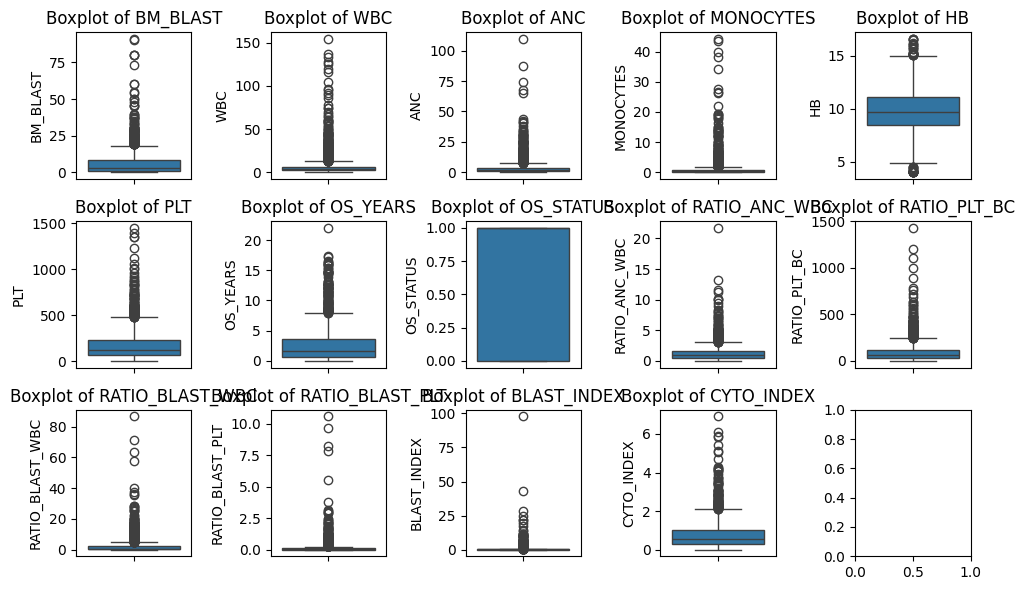

In [ ]:
#@title Boxplot to identify outliers
float_col=df_new.select_dtypes("float").columns
fig, axes = plt.subplots(3, 5, figsize=(10, 6))
axes = axes.flatten()
for i, col in enumerate(float_col):
  sns.boxplot(df_new, y=col, ax=axes[i])
  axes[i].set_title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()
#@markdown Regards these boxplots "BM_BLAST", "WBC", "ANC", "MONOCYTES", "PLT" present outliers and asymetric distribution.
#@markdown I will apply logarithmic scale to these variables

In [ ]:
#@title Apply logaritimic transformation
var_with_outlier=["BM_BLAST", "WBC", "ANC", "MONOCYTES", "PLT", "HB",
                  'RATIO_ANC_WBC', 'RATIO_PLT_BC', 'RATIO_BLAST_WBC', 'RATIO_BLAST_PLT',
                  "CYTO_INDEX", "BLAST_INDEX"]
for col in var_with_outlier:
  df_new[f'{col}_NEW']=(df_new[col])

In [ ]:
from scipy.stats.mstats import winsorize
var_with_outlier=["MONOCYTES", 'RATIO_BLAST_PLT']
for col in var_with_outlier:
  df_new[f'{col}_NEW']=winsorize(df_new[f'{col}_NEW'], limits=[0.2, 0.2])

var_with_outlier=["WBC", "ANC", "HB", 'RATIO_ANC_WBC', 'RATIO_PLT_BC', 'RATIO_BLAST_WBC']
for col in var_with_outlier:
  df_new[f'{col}_NEW']=winsorize(df_new[f'{col}_NEW'], limits=[0.1, 0.1])

var_with_outlier=["BM_BLAST", "PLT"]
for col in var_with_outlier:
  df_new[f'{col}_NEW']=winsorize(df_new[f'{col}_NEW'], limits=[0.01, 0.01])

In [ ]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173 entries, 0 to 3172
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   ID                   3173 non-null   category
 1   CENTER               3173 non-null   category
 2   BM_BLAST             3094 non-null   float64 
 3   WBC                  2944 non-null   float64 
 4   ANC                  3032 non-null   float64 
 5   MONOCYTES            2629 non-null   float64 
 6   HB                   3098 non-null   float64 
 7   PLT                  3087 non-null   float64 
 8   OS_YEARS             3173 non-null   float64 
 9   OS_STATUS            3173 non-null   float64 
 10  RATIO_ANC_WBC        2893 non-null   float64 
 11  RATIO_PLT_BC         2891 non-null   float64 
 12  RATIO_BLAST_WBC      2917 non-null   float64 
 13  RATIO_BLAST_PLT      3060 non-null   float64 
 14  ANEMIA               3173 non-null   int64   
 15  SEVERE_ANEMIA        

<Axes: ylabel='BM_BLAST_NEW'>

Text(0.5, 1.0, 'Boxplot of BM_BLAST_NEW')

<Axes: ylabel='WBC_NEW'>

Text(0.5, 1.0, 'Boxplot of WBC_NEW')

<Axes: ylabel='ANC_NEW'>

Text(0.5, 1.0, 'Boxplot of ANC_NEW')

<Axes: ylabel='HB_NEW'>

Text(0.5, 1.0, 'Boxplot of HB_NEW')

<Axes: ylabel='MONOCYTES_NEW'>

Text(0.5, 1.0, 'Boxplot of MONOCYTES_NEW')

<Axes: ylabel='PLT_NEW'>

Text(0.5, 1.0, 'Boxplot of PLT_NEW')

<Axes: ylabel='RATIO_ANC_WBC_NEW'>

Text(0.5, 1.0, 'Boxplot of RATIO_ANC_WBC_NEW')

<Axes: ylabel='RATIO_PLT_BC_NEW'>

Text(0.5, 1.0, 'Boxplot of RATIO_PLT_BC_NEW')

<Axes: ylabel='RATIO_BLAST_WBC_NEW'>

Text(0.5, 1.0, 'Boxplot of RATIO_BLAST_WBC_NEW')

<Axes: ylabel='RATIO_BLAST_PLT_NEW'>

Text(0.5, 1.0, 'Boxplot of RATIO_BLAST_PLT_NEW')

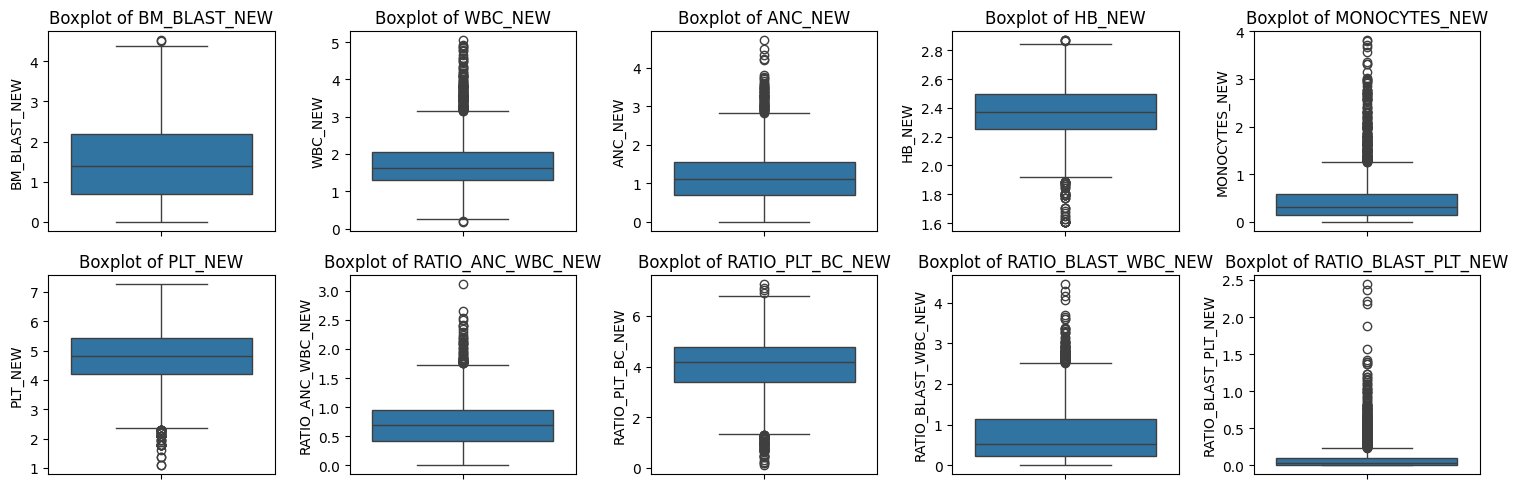

<Axes: xlabel='BM_BLAST', ylabel='Density'>

<Axes: xlabel='BM_BLAST', ylabel='Density'>

Text(0.5, 1.0, 'Dist BM_BLAST before/after')

<Axes: xlabel='WBC', ylabel='Density'>

<Axes: xlabel='WBC', ylabel='Density'>

Text(0.5, 1.0, 'Dist WBC before/after')

<Axes: xlabel='ANC', ylabel='Density'>

<Axes: xlabel='ANC', ylabel='Density'>

Text(0.5, 1.0, 'Dist ANC before/after')

<Axes: xlabel='HB', ylabel='Density'>

<Axes: xlabel='HB', ylabel='Density'>

Text(0.5, 1.0, 'Dist HB before/after')

<Axes: xlabel='MONOCYTES', ylabel='Density'>

<Axes: xlabel='MONOCYTES', ylabel='Density'>

Text(0.5, 1.0, 'Dist MONOCYTES before/after')

<Axes: xlabel='PLT', ylabel='Density'>

<Axes: xlabel='PLT', ylabel='Density'>

Text(0.5, 1.0, 'Dist PLT before/after')

<Axes: xlabel='RATIO_ANC_WBC', ylabel='Density'>

<Axes: xlabel='RATIO_ANC_WBC', ylabel='Density'>

Text(0.5, 1.0, 'Dist RATIO_ANC_WBC before/after')

<Axes: xlabel='RATIO_PLT_BC', ylabel='Density'>

<Axes: xlabel='RATIO_PLT_BC', ylabel='Density'>

Text(0.5, 1.0, 'Dist RATIO_PLT_BC before/after')

<Axes: xlabel='RATIO_BLAST_WBC', ylabel='Density'>

<Axes: xlabel='RATIO_BLAST_WBC', ylabel='Density'>

Text(0.5, 1.0, 'Dist RATIO_BLAST_WBC before/after')

<Axes: xlabel='RATIO_BLAST_PLT', ylabel='Density'>

<Axes: xlabel='RATIO_BLAST_PLT', ylabel='Density'>

Text(0.5, 1.0, 'Dist RATIO_BLAST_PLT before/after')

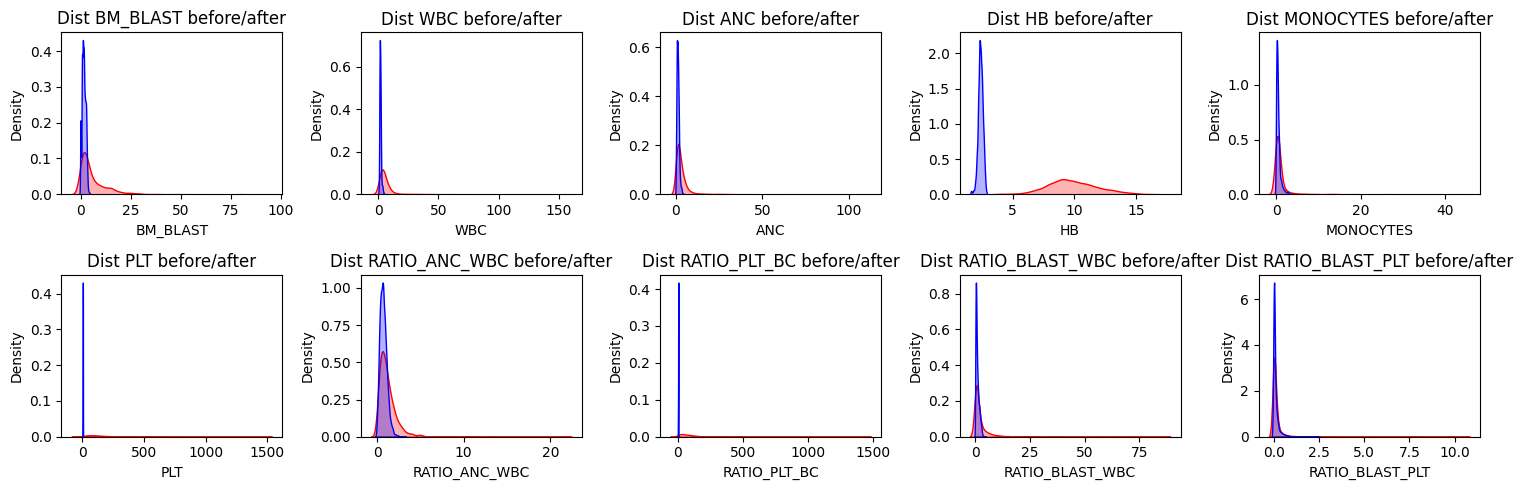

In [ ]:
#@title Check transformation
var_with_outlier=['BM_BLAST', 'WBC', 'ANC', 'HB', 'MONOCYTES', 'PLT', 'RATIO_ANC_WBC', 'RATIO_PLT_BC', 'RATIO_BLAST_WBC', 'RATIO_BLAST_PLT']
fig, axes = plt.subplots(2, 5, figsize=(15, 5))
axes = axes.flatten()
for i, col in enumerate(var_with_outlier):
  sns.boxplot(df_new, y=f'{col}_NEW', ax=axes[i])
  axes[i].set_title(f'Boxplot of {col}_NEW')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 5, figsize=(15, 5))
axes = axes.flatten()

for i, col in enumerate(var_with_outlier):
    sns.kdeplot(df_new[col], label="Before", color="red", fill=True, alpha=0.3, ax=axes[i])
    sns.kdeplot(df_new[f'{col}_NEW'], label="After", color="blue", fill=True, alpha=0.3, ax=axes[i])
    axes[i].set_title(f"Dist {col} before/after")
plt.tight_layout()
plt.show()

##### Standardization

In [ ]:
#@title Standard scaler
sscaler_clinvar=StandardScaler()
cols_to_scale=['HB_NEW', 'BM_BLAST_NEW', 'RATIO_ANC_WBC_NEW', 'RATIO_PLT_BC_NEW', 'WBC_NEW',
       'ANC_NEW', 'MONOCYTES_NEW', 'PLT_NEW', 'RATIO_BLAST_WBC_NEW', 'RATIO_BLAST_PLT_NEW']
sscaler_clinvar.fit(df_new[cols_to_scale])
df_new[cols_to_scale] = sscaler_clinvar.transform(df_new[cols_to_scale])

StandardScaler()

<Axes: ylabel='BM_BLAST_NEW'>

Text(0.5, 1.0, 'Boxplot of BM_BLAST_NEW')

<Axes: ylabel='WBC_NEW'>

Text(0.5, 1.0, 'Boxplot of WBC_NEW')

<Axes: ylabel='HB_NEW'>

Text(0.5, 1.0, 'Boxplot of HB_NEW')

<Axes: ylabel='ANC_NEW'>

Text(0.5, 1.0, 'Boxplot of ANC_NEW')

<Axes: ylabel='MONOCYTES_NEW'>

Text(0.5, 1.0, 'Boxplot of MONOCYTES_NEW')

<Axes: ylabel='PLT_NEW'>

Text(0.5, 1.0, 'Boxplot of PLT_NEW')

<Axes: ylabel='RATIO_ANC_WBC_NEW'>

Text(0.5, 1.0, 'Boxplot of RATIO_ANC_WBC_NEW')

<Axes: ylabel='RATIO_PLT_BC_NEW'>

Text(0.5, 1.0, 'Boxplot of RATIO_PLT_BC_NEW')

<Axes: ylabel='RATIO_BLAST_WBC_NEW'>

Text(0.5, 1.0, 'Boxplot of RATIO_BLAST_WBC_NEW')

<Axes: ylabel='RATIO_BLAST_PLT_NEW'>

Text(0.5, 1.0, 'Boxplot of RATIO_BLAST_PLT_NEW')

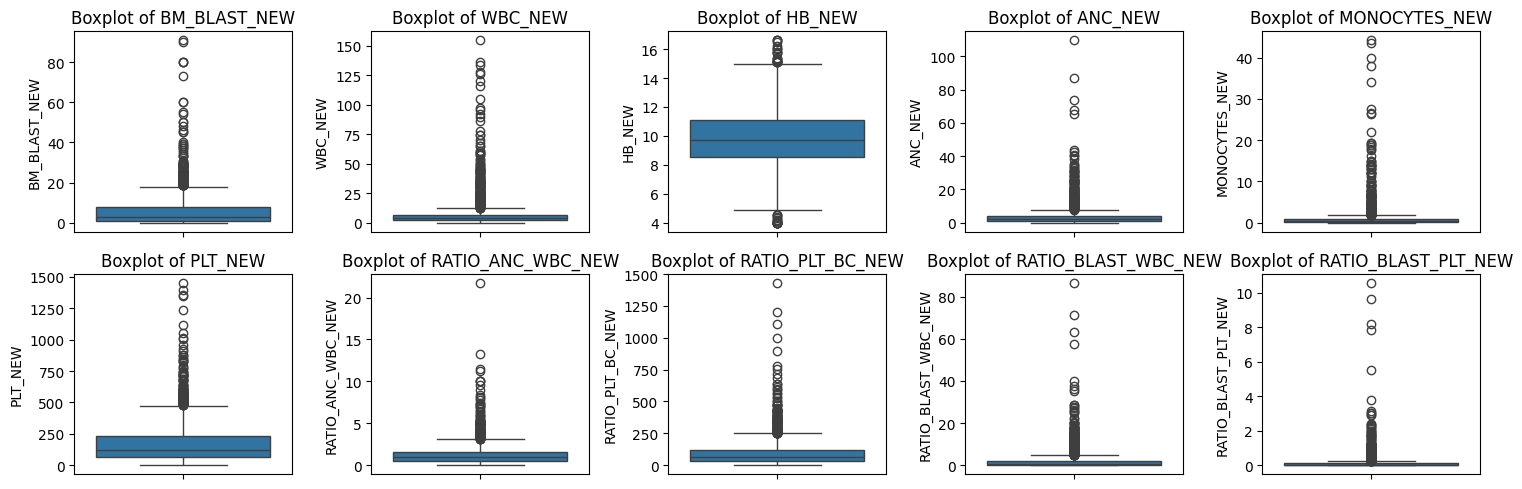

In [ ]:
#@title Check transformation
var_with_outlier=["BM_BLAST", "WBC", "HB", "ANC", "MONOCYTES", "PLT", "RATIO_ANC_WBC", "RATIO_PLT_BC", "RATIO_BLAST_WBC", "RATIO_BLAST_PLT"]
fig, axes = plt.subplots(2, 5, figsize=(15, 5))
axes = axes.flatten()
for i, col in enumerate(var_with_outlier):
  sns.boxplot(df_new, y=f'{col}_NEW', ax=axes[i])
  axes[i].set_title(f'Boxplot of {col}_NEW')
plt.tight_layout()
plt.show()

##### Features selection

,BM_BLAST_NEW,WBC_NEW,ANC_NEW,MONOCYTES_NEW,PLT_NEW,RATIO_ANC_WBC_NEW,RATIO_PLT_BC_NEW,RATIO_BLAST_WBC_NEW,RATIO_BLAST_PLT_NEW,HB_NEW
BM_BLAST_NEW,1.000000,-0.184223,-0.250685,-0.120421,-0.318050,-0.320204,-0.262778,0.866719,0.871243,-0.040173
WBC_NEW,-0.184223,1.000000,0.897488,0.654380,0.235459,0.388281,-0.252528,-0.583523,-0.229041,0.082185
ANC_NEW,-0.250685,0.897488,1.000000,0.526565,0.266956,0.704713,-0.061215,-0.600149,-0.290121,0.049782
MONOCYTES_NEW,-0.120421,0.654380,0.526565,1.000000,0.143235,0.093372,-0.265067,-0.395183,-0.142610,0.163196
PLT_NEW,-0.318050,0.235459,0.266956,0.143235,1.000000,0.242254,0.784260,-0.332766,-0.693021,-0.006564
RATIO_ANC_WBC_NEW,-0.320204,0.388281,0.704713,0.093372,0.242254,1.000000,0.321243,-0.398415,-0.330670,-0.020720
RATIO_PLT_BC_NEW,-0.262778,-0.252528,-0.061215,-0.265067,0.784260,0.321243,1.000000,-0.060891,-0.556094,-0.069973
RATIO_BLAST_WBC_NEW,0.866719,-0.583523,-0.600149,-0.395183,-0.332766,-0.398415,-0.060891,1.000000,0.794773,-0.061303
RATIO_BLAST_PLT_NEW,0.871243,-0.229041,-0.290121,-0.142610,-0.693021,-0.330670,-0.556094,0.794773,1.000000,-0.025243
HB_NEW,-0.040173,0.082185,0.049782,0.163196,-0.006564,-0.020720,-0.069973,-0.061303,-0.025243,1.000000


[('BM_BLAST_NEW', 'RATIO_BLAST_WBC_NEW'),
 ('BM_BLAST_NEW', 'RATIO_BLAST_PLT_NEW'),
 ('WBC_NEW', 'ANC_NEW'),
 ('WBC_NEW', 'MONOCYTES_NEW'),
 ('ANC_NEW', 'WBC_NEW'),
 ('ANC_NEW', 'RATIO_ANC_WBC_NEW'),
 ('ANC_NEW', 'RATIO_BLAST_WBC_NEW'),
 ('MONOCYTES_NEW', 'WBC_NEW'),
 ('PLT_NEW', 'RATIO_PLT_BC_NEW'),
 ('PLT_NEW', 'RATIO_BLAST_PLT_NEW'),
 ('RATIO_ANC_WBC_NEW', 'ANC_NEW'),
 ('RATIO_PLT_BC_NEW', 'PLT_NEW'),
 ('RATIO_BLAST_WBC_NEW', 'BM_BLAST_NEW'),
 ('RATIO_BLAST_WBC_NEW', 'ANC_NEW'),
 ('RATIO_BLAST_WBC_NEW', 'RATIO_BLAST_PLT_NEW'),
 ('RATIO_BLAST_PLT_NEW', 'BM_BLAST_NEW'),
 ('RATIO_BLAST_PLT_NEW', 'PLT_NEW'),
 ('RATIO_BLAST_PLT_NEW', 'RATIO_BLAST_WBC_NEW')]

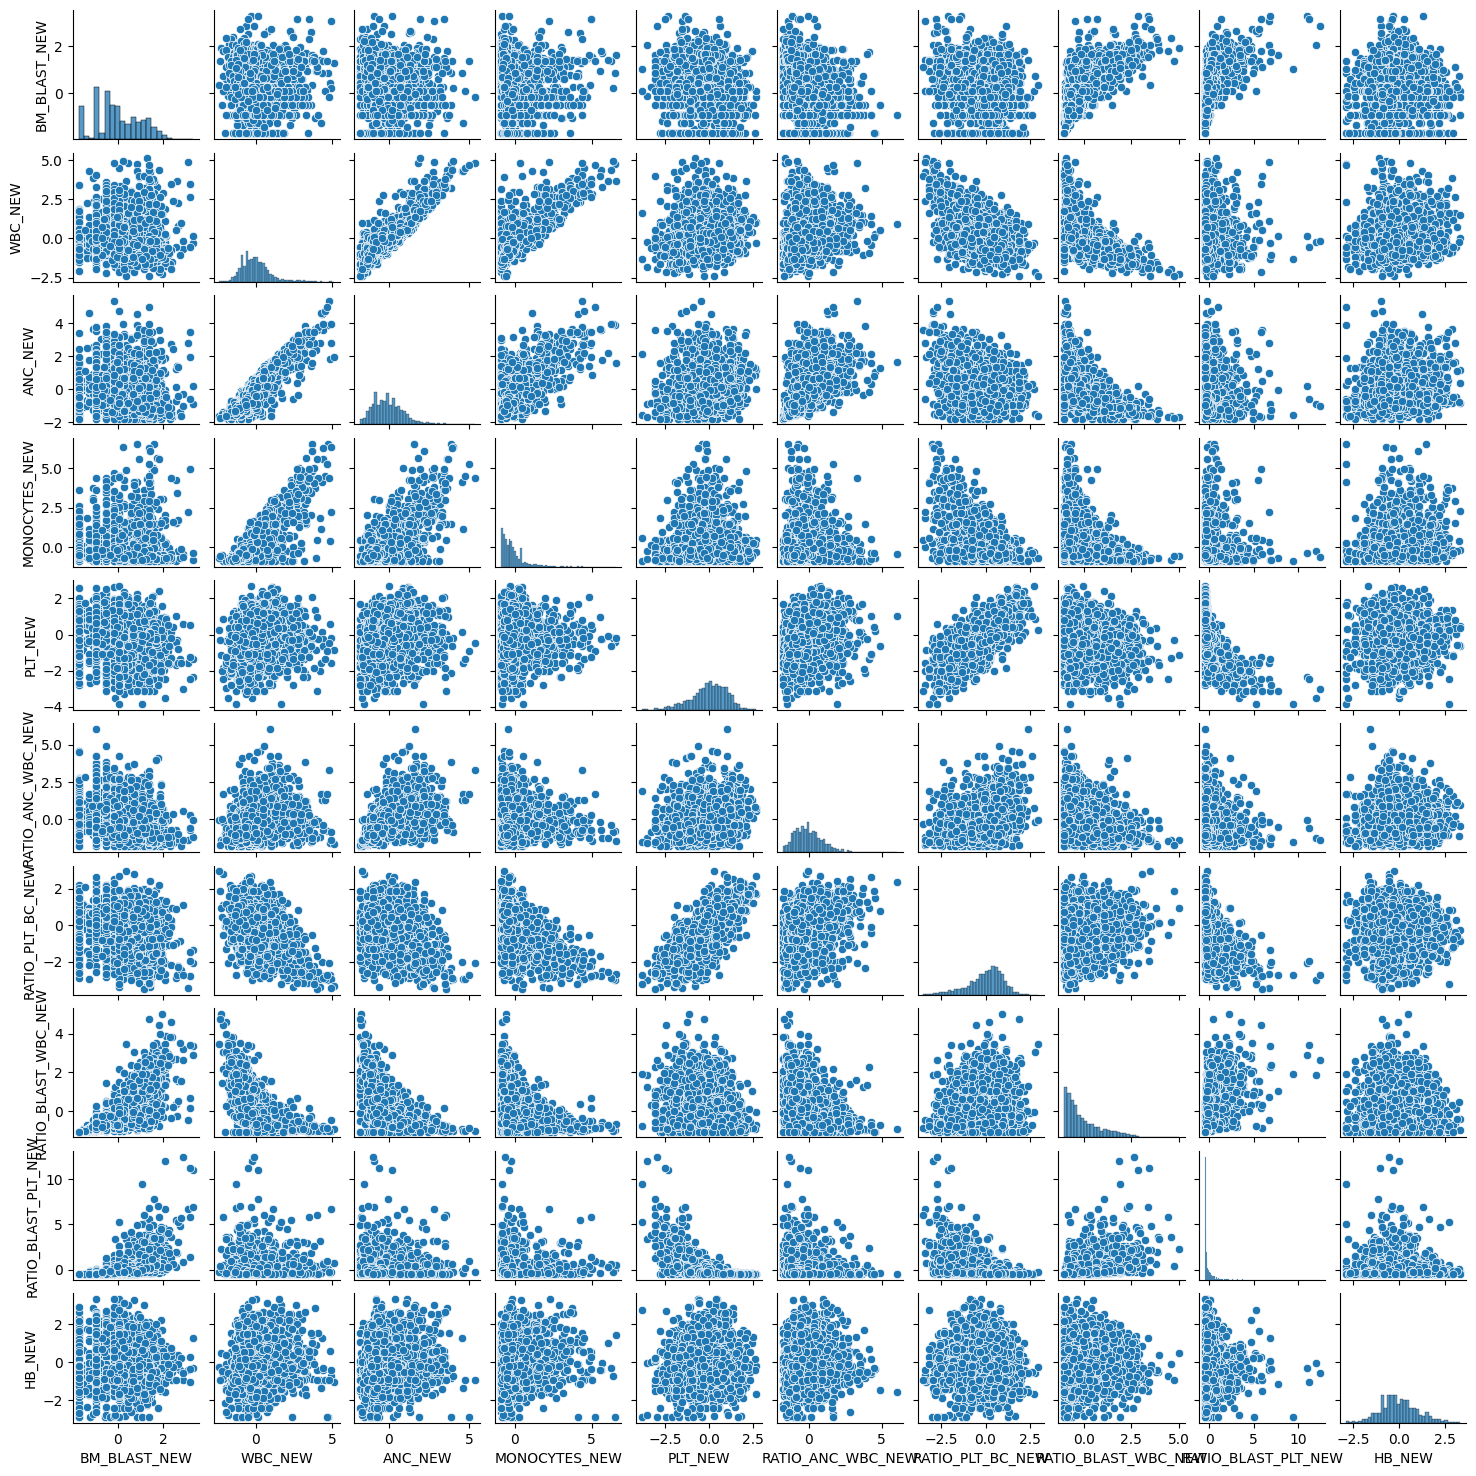

In [ ]:
# @title Remove highly correlated variables
cor=df_new[df_new.columns[df_new.columns.str.contains(r"_NEW", regex=True)]].corr("spearman")
cor
high_cor = [(var1, var2) for var1 in cor.columns
                for var2 in cor.columns
                if var1 != var2 and abs(cor.loc[var1, var2]) > 0.6]
high_cor
## @title Pairplot
new_col=df_new.columns[df_new.columns.str.contains(r"_NEW", regex=True)].tolist()
sns.pairplot(df_new[new_col], kind='scatter', height=1.5)
plt.show()
#@markdown To be removed: ANC and WBC highly correlated 0.89. Then remove WBC

##### Features extractions

###### Create high risk genetics features

In [ ]:
#@title List of translocation Inversion Deletion implied in leukemya in literrature
high_risk_list=[
    # deletion 5 and 7
    (r"del\(5\)", "HIGHRISK_DEL5"), (r"-5", "HIGHRISK_DEL5"), (r"- 5", "HIGHRISK_DEL5"), (r"del\(5*.+\)", "HIGHRISK_DEL5"), (r"del5q", "HIGHRISK_DEL5"),
    (r"del\(7\)", "HIGHRISK_DEL7"), (r"-7", "HIGHRISK_DEL7"), (r"- 7", "HIGHRISK_DEL7"), (r"del\(7*.+\)", "HIGHRISK_DEL7"), (r"del7q", "HIGHRISK_DEL7"),
    # deletion 5q
    (r"del\(5\)[^)]*.+q31*.+\)", "HIGHRISK_DEL5Q"), (r"del\(5\)[^)]*.+q32*.+\)", "HIGHRISK_DEL5Q"), (r"del\(5\)[^)]*.+q33*.+\)", "HIGHRISK_DEL5Q"),
    (r"del\(5\)[^)]*.+q34*.+\)", "HIGHRISK_DEL5Q"), (r"del\(5\)[^)]*.+q35*.+\)", "HIGHRISK_DEL5Q"), (r"del\(5\)[^)]*.+q36*.+\)", "HIGHRISK_DEL5Q"),
    # deletion 7q7p
    (r"del\(7\)[^)]*.+q22*.+\)", "HIGHRISK_DEL7QP"), (r"del\(7\)[^)]*.+q31*.+\)", "HIGHRISK_DEL7QP"), (r"del\(7\)[^)]*.+q32*.+\)", "HIGHRISK_DEL7QP"),
    (r"del\(7\)[^)]*.+q33*.+\)", "HIGHRISK_DEL7QP"), (r"del\(7\)[^)]*.+q35*.+\)", "HIGHRISK_DEL7QP"), (r"del\(7\)[^)]*.+q36*.+\)", "HIGHRISK_DEL7QP"),
    (r"del\(7\)[^)]*.+p12*.+\)", "HIGHRISK_DEL7QP"), (r"del\(7\)[^)]*.+p14*.+\)", "HIGHRISK_DEL7QP"), (r"del\(7\)[^)]\(p14-p15\)", "HIGHRISK_DEL7QP"),
    (r"del\(7\)[^)]*.+p15*.+", "HIGHRISK_DEL7QP"),
    # deletion 17
    (r"del\(17\)", "HIGHRISK_DEL17"),
    # deletion 20Q
    (r"del\(20\)[^)]*.+q13*.+\)", "HIGHRISK_DEL20Q"), (r"del\(20\)[^)]*.+q12*.+\)", "HIGHRISK_DEL20Q"),
    (r"del\(20\)[^)]*.+q11*.+\)", "HIGHRISK_DEL20Q"),
    (r"del\(20\)[^)]*.+q1?\)", "HIGHRISK_DEL20Q"),
    # deletion 3Q
    (r"del\(3\)*.+q", "HIGHRISK_DEL3QP"), (r"del\(3\)*.+p", "HIGHRISK_DEL3QP"),
    # Inversion
    (r"inv\(9\)", "HIGHRISK_INV9"), (r"inv\(11\)", "HIGHRISK_INV11"),
    # Dicentrie
    (r"dic\(5;17\)", "HIGHRISK_DIC"), (r"dic\(7;12\)", "HIGHRISK_DIC"), (r"dic\(9;20\)", "HIGHRISK_DIC"),
    (r"dic\(1;7\)", "HIGHRISK_DIC"), (r"dic\(3;5\)", "HIGHRISK_DIC"), (r"dic\(6;9\)", "HIGHRISK_DIC"),
    (r"dic\(9;22\)", "HIGHRISK_DIC"),
    # Dérivés
    (r"der\(1;7\)", "HIGHRISK_DER"), (r"der\(3\)", "HIGHRISK_DER"), (r"der\(5\)", "HIGHRISK_DER"),
    (r"der\(7\)", "HIGHRISK_DER"), (r"der\(9\)", "HIGHRISK_DER"), (r"der\(17\)", "HIGHRISK_DER"),
    (r"der\(22\)", "HIGHRISK_DER"),
    # Translocations
    (r"t\(3;3\)[^)]*.+q26*.+\)", "HIGHRISK_T33"), (r"inv\(3\)[^)]*.+q26*.+\)", "HIGHRISK_T33"),
    (r"t\(15;17\)", "HIGHRISK_T1517"),
    (r"t\(6;9\)", "HIGHRISK_T69"),  (r"t\(9;22\)", "HIGHRISK_T922"),
    (r"t\(8;16\)", "HIGHRISK_T816"), (r"t\(1;22\)", "HIGHRISK_T122"),
    (r"t\(5;7\)", "HIGHRISK_T57"), (r"t\(9;11\)", "HIGHRISK_T911"),
    # tRISOMIE
    (r"\+4", "HIGHRISK_TRISO4"), (r"\+8", "HIGHRISK_TRISO8"), (r"plus8", "HIGHRISK_TRISO8"), (r"tris8", "HIGHRISK_TRISO8"), (r"triso*.+8", "HIGHRISK_TRISO8"),
    (r"\+11", "HIGHRISK_TRISO11"), (r"\+13", "HIGHRISK_TRISO13"),
    # Add
    (r"add\(3\)", "HIGHRISK_ADD3"), (r"add\(5\)", "HIGHRISK_ADD5"), (r"add\(7\)", "HIGHRISK_ADD7"), (r"add\(11\)", "HIGHRISK_ADD11"),
    (r"add\(17\)", "HIGHRISK_ADD17"), (r"add\(21\)", "HIGHRISK_ADD21"),
    # Chromosomes marqués
    (r"\+mar", "HIGHRISK_MAR"), (r"\+*.+mar", "HIGHRISK_MAR"),
    # More dans 3 abnomarlities
    (r">3abnormalities", "HIGHRISK_COMPLEX"), (r"complex", "HIGHRISK_COMPLEX"), (r">3| > 3", "HIGHRISK_COMPLEX"),
    (r"\.+abnormal.+", "HIGHRISK_COMPLEX"), (r"multiples", "HIGHRISK_COMPLEX")
]

In [ ]:
#@title Identify and encode risk
def high_risk_cyto(cyto_str):
    if not isinstance(cyto_str, str):
        return "none"
    cyto_lower=cyto_str.lower()
    found_categories=set()
    for pattern, category in high_risk_list:
        if re.search(pattern, cyto_lower):
            found_categories.add(category)
    if found_categories:
        return " ".join(found_categories)

cytogenetic_risk=clin_train_df[["ID", "CYTOGENETICS"]].copy()
cytogenetic_risk["CYTOGENETICS_RISK"]=cytogenetic_risk["CYTOGENETICS"].apply(high_risk_cyto)
cytogenetic_risk=cytogenetic_risk["CYTOGENETICS_RISK"].str.get_dummies(sep=" ").reset_index(drop=True).copy()
cytogenetic_risk.loc[:,"ID"]=clin_train_df["ID"].reset_index(drop=True)
cytogenetic_risk.loc[:,"CYTOGENETICS"]=clin_train_df["CYTOGENETICS"]
cytogenetic_risk["HIGHRISK_DEL57"]=np.where(cytogenetic_risk["HIGHRISK_DEL5"]+cytogenetic_risk["HIGHRISK_DEL7"]>1, 1, 0)

In [ ]:
def find_normal_cyto(cyto_str):
  if not isinstance(cyto_str, str):
    return np.nan
  cyto_lower=cyto_str.lower()
  pattern = r'^46,xx$|^46,xx\[\d+\]$|^46,xy\[\d+\]$|^46,xy$|normal'
  if bool(re.match(pattern, cyto_lower))==True:
    return 1
  else:
    return 0
cytogenetic_risk["CAROTYPE_NORMAL"]=cytogenetic_risk["CYTOGENETICS"].apply(find_normal_cyto)

In [ ]:
# Fonction pour compter les anomalies cytogénétiques
def count_cytogenetic_abnormalities(cyto_str):
  if not isinstance(cyto_str, str):
    return np.nan
  cyto_lower=cyto_str.lower()
  pattern = re.compile(r"""
        \bdel\([^\)]+\)|\bdel\d*.+\b|\bdel\d\b|\bt\([^)]+\)|\binv\([^)]+\)|\+\d+\b|-\d+\b|\bi\([^)]+\)|\bder\([^)]+\)|
        \bdic\([^)]+\)\b|\bmar|\badd\([^\)]+\)|\bcomplex\b|\bcomplex*.+\b|\b\*.+multiple*.+\b|\babnormal\b|\b\d\+*abnormalities\+*\b|
        \babnormalities\b|\btriso\b|\b>3\b|\bplus8\b|\-x|\-y|\+y|\+x|\bidic\b|\bdup\b|\btris8\b|\bmar\b|\bdic\b""",
                       re.VERBOSE| re.IGNORECASE)

    # Trouver toutes les anomalies correspondantes
  abnormalities = pattern.findall(cyto_lower)

    # Retourner le nombre d'anomalies détectées
  return len(abnormalities)

# Créer une nouvelle variable qui contient le nombre d'anomalies pour chaque patient

cytogenetic_risk["NABNORMAL"]=clin_train_df["CYTOGENETICS"].apply(count_cytogenetic_abnormalities)
cytogenetic_risk["NABNORMAL_GROUP"]=np.where(cytogenetic_risk["NABNORMAL"].isna(), "NABNORMAL_GROUP_NONE", np.where(cytogenetic_risk["NABNORMAL"]==0, "NABNORMAL_GROUP_0", np.where(cytogenetic_risk["NABNORMAL"]==1, "NABNORMAL_GROUP_1", np.where(cytogenetic_risk["NABNORMAL"]==2, "NABNORMAL_GROUP_2","NABNORMAL_GROUP_3"))))
cytogenetic_risk["CAROTYPE_COMPLEX"]=np.where((cytogenetic_risk["NABNORMAL"]>=3) | (cytogenetic_risk['HIGHRISK_COMPLEX']==1), 1, 0)

In [ ]:
nbabnormal=cytogenetic_risk["NABNORMAL_GROUP"].str.get_dummies(sep=" ")
nbabnormal.loc[:,"ID"]=clin_train_df["ID"]
cytogenetic_risk=cytogenetic_risk.merge(nbabnormal, on="ID", how="left")

In [ ]:
import numpy as np
import re

# Fonction pour compter les anomalies cytogénétiques
def count_cytogenetic_abnormalities(cyto_str, pattern_str):
    if not isinstance(cyto_str, str):
        return np.nan
    cyto_lower = cyto_str.lower()
    pattern = re.compile(pattern_str, re.VERBOSE | re.IGNORECASE)

    # Trouver toutes les anomalies correspondantes
    abnormalities = pattern.findall(cyto_lower)

    # Retourner le nombre d'anomalies détectées
    return len(abnormalities)

# Définir ton pattern à part
pattern_del = r"""\bdel\([^\)]+\)\bdel\d*.+\b|\bdel\d*\b|-\d+\b|-\d*"""
pattern_add = r"""\badd\([^\)]+\)\b|\+\d+\b|\+\d*"""
pattern_transloc = r"""\bt\([^)]+\)|\bt\b|\bt\d*"""
pattern_inv = r"""\binv\d*\b"""
pattern_der = r"""\bder\d*\b"""
pattern_dic = r"""\bdic\d*\b|\bidic\d*\b"""
pattern_dup = r"""\bdup\d*\b"""
pattern_mar = r"""\bmar\d*\b"""
cytogenetic_risk["NDEL"] = clin_train_df["CYTOGENETICS"].apply(lambda x: count_cytogenetic_abnormalities(x, pattern_del))
cytogenetic_risk["NADD"] = clin_train_df["CYTOGENETICS"].apply(lambda x: count_cytogenetic_abnormalities(x, pattern_add))
cytogenetic_risk["NTRANSLOC"] = clin_train_df["CYTOGENETICS"].apply(lambda x: count_cytogenetic_abnormalities(x, pattern_transloc))
cytogenetic_risk["NINV"] = clin_train_df["CYTOGENETICS"].apply(lambda x: count_cytogenetic_abnormalities(x, pattern_inv))
cytogenetic_risk["NDER"] = clin_train_df["CYTOGENETICS"].apply(lambda x: count_cytogenetic_abnormalities(x, pattern_der))
cytogenetic_risk["NDIC"] = clin_train_df["CYTOGENETICS"].apply(lambda x: count_cytogenetic_abnormalities(x, pattern_dic))
cytogenetic_risk["NDUP"] = clin_train_df["CYTOGENETICS"].apply(lambda x: count_cytogenetic_abnormalities(x, pattern_dup))
cytogenetic_risk["NMAR"] = clin_train_df["CYTOGENETICS"].apply(lambda x: count_cytogenetic_abnormalities(x, pattern_mar))

In [ ]:
def count_chromosomes(cyto_str):
    # Expression régulière pour capturer le nombre de chromosomes mentionné
    # Cela recherche les nombres après les termes comme "46,XY", "47,XX", etc.
    if not isinstance(cyto_str, str):
      return np.nan
    cyto_lower=cyto_str.lower()
    pattern = r'(\d{2}),[xy]{2}'

    # Trouver tous les chromosomes mentionnés dans les résultats
    chromosomes = re.findall(pattern, cyto_lower)
    # Compter les chromosomes distincts mentionnés
    if len(chromosomes)>2:
      return 0
    if len(chromosomes)==2:
      if chromosomes[0]=="46" and chromosomes[1]=="46":
        return 1
      else :
        return 0
    elif len(chromosomes)==1:
      if "46" in chromosomes:
        return 1
      else :
        return 0
    else :
      return np.nan

In [ ]:
cytogenetic_risk["CYTO_NBCHR"]=cytogenetic_risk["CYTOGENETICS"].apply(count_chromosomes)

In [ ]:
#@title Merge cytogenetic risk with clinical train data
clin_train_df_new=df_new.merge(cytogenetic_risk, on="ID", how="left")

In [ ]:
clin_train_df_new.drop(columns=["none", "OS_YEARS", "OS_STATUS", "CYTOGENETICS"], inplace=True)

In [ ]:
clin_train_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173 entries, 0 to 3172
Data columns (total 82 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   ID                    3173 non-null   object  
 1   CENTER                3173 non-null   category
 2   BM_BLAST              3094 non-null   float64 
 3   WBC                   2944 non-null   float64 
 4   ANC                   3032 non-null   float64 
 5   MONOCYTES             2629 non-null   float64 
 6   HB                    3098 non-null   float64 
 7   PLT                   3087 non-null   float64 
 8   RATIO_ANC_WBC         2893 non-null   float64 
 9   RATIO_PLT_BC          2891 non-null   float64 
 10  RATIO_BLAST_WBC       2917 non-null   float64 
 11  RATIO_BLAST_PLT       3060 non-null   float64 
 12  ANEMIA                3173 non-null   int64   
 13  SEVERE_ANEMIA         3173 non-null   int64   
 14  THROMBO               3173 non-null   int64   
 15  SEVE

###### Identify monosomal carotype

In [ ]:
#@title Function to retrieve monosomal carotype
def detect_caryotype_monosomal(cyto_str):
  if not isinstance(cyto_str, str):
    return np.nan
  cyto_lower=cyto_str.lower()
  anomalies = re.findall(r'[-+]\d+|del\(\d+q?\d*\)', cyto_lower)
  monosomies = {an for an in anomalies if an.startswith('-') and an[1:].isdigit()}
  deletions = {an for an in anomalies if "del" in an}
  if len(monosomies) >= 2 or (len(monosomies) >= 1 and len(deletions) >= 1):
    return 1
  return 0

monosomal=clin_train_df[["ID", "CYTOGENETICS"]].copy()
monosomal["MONOSOMAL"]=monosomal["CYTOGENETICS"].apply(detect_caryotype_monosomal).reset_index(drop=True)
monosomal.loc[:,"ID"]=clin_train_df["ID"].reset_index(drop=True)
monosomal.drop(columns=["CYTOGENETICS"], inplace=True)

In [ ]:
#@title Merge monosomal carotype with clinical train data
clin_train_df_new=clin_train_df_new.merge(monosomal, on="ID", how="left")

In [ ]:
#@title Calculate IPSS SCORE
clin_train_df_new['IPSS_R_SCORE_NEW'] = clin_train_df_new["BM_BLAST"] * 0.4 + clin_train_df_new["HB"] * (-0.3) + clin_train_df_new["PLT"] * (-0.2) + clin_train_df_new["NABNORMAL"] * 0.5

In [ ]:
clin_train_df_new[['BM_BLAST_NEW', 'WBC_NEW', 'ANC_NEW', 'HB_NEW',
       'MONOCYTES_NEW', 'HB_NEW', 'PLT_NEW', 'RATIO_ANC_WBC_NEW',
       'RATIO_PLT_BC_NEW', 'RATIO_BLAST_WBC_NEW', 'RATIO_BLAST_PLT_NEW',
       'IPSS_R_SCORE_NEW', 'BLAST_INDEX_NEW', 'CYTO_INDEX_NEW']].describe()

,BM_BLAST_NEW,WBC_NEW,ANC_NEW,HB_NEW,MONOCYTES_NEW,HB_NEW,PLT_NEW,RATIO_ANC_WBC_NEW,RATIO_PLT_BC_NEW,RATIO_BLAST_WBC_NEW,RATIO_BLAST_PLT_NEW,IPSS_R_SCORE_NEW,BLAST_INDEX_NEW,CYTO_INDEX_NEW
count,3094.000000,2944.000000,3032.000000,3098.000000,2629.000000,3098.000000,3087.000000,2893.000000,2891.000000,2917.000000,3060.000000,2778.000000,2917.000000,3083.000000
mean,6.071041,6.597417,3.286438,9.861709,0.971848,9.861709,167.070758,1.237930,88.207194,2.147292,0.128504,-32.918577,0.489291,0.724796
std,7.662941,10.405641,5.308014,2.030977,2.710523,2.030977,150.234265,1.188898,95.829786,4.399662,0.436046,30.332360,2.444761,0.652073
min,0.000000,0.200000,0.000000,4.000000,0.000000,4.000000,2.000000,0.000000,0.121065,0.000000,0.000000,-281.220000,0.000000,0.003556
25%,1.000000,2.700000,1.000000,8.500000,0.149000,8.500000,65.000000,0.515152,28.571429,0.250000,0.007353,-46.545500,0.061200,0.273249
50%,3.000000,4.100000,2.000000,9.700000,0.370000,9.700000,123.000000,0.981982,64.601770,0.694444,0.025974,-24.940000,0.140100,0.550898
75%,8.000000,6.700000,3.700000,11.100000,0.792000,11.100000,229.500000,1.564444,116.583333,2.142857,0.103448,-11.992500,0.327600,1.006222
max,91.000000,154.400000,109.620000,16.600000,44.200000,16.600000,1451.000000,21.750000,1430.000000,86.666667,10.582011,37.150000,97.820000,6.910400


In [ ]:
clin_train_df_new.columns

Index(['ID', 'CENTER', 'BM_BLAST', 'WBC', 'ANC', 'MONOCYTES', 'HB', 'PLT',
       'RATIO_ANC_WBC', 'RATIO_PLT_BC', 'RATIO_BLAST_WBC', 'RATIO_BLAST_PLT',
       'BM_BLAST_NEW', 'WBC_NEW', 'ANC_NEW', 'MONOCYTES_NEW', 'PLT_NEW',
       'HB_NEW', 'RATIO_ANC_WBC_NEW', 'RATIO_PLT_BC_NEW',
       'RATIO_BLAST_WBC_NEW', 'RATIO_BLAST_PLT_NEW', 'CYTOGENETICS_EMBED_0',
       'CYTOGENETICS_EMBED_1', 'CYTOGENETICS_EMBED_2', 'CYTOGENETICS_EMBED_3',
       'CYTOGENETICS_EMBED_4', 'CYTOGENETICS_EMBED_5', 'CYTOGENETICS_EMBED_6',
       'CYTOGENETICS_EMBED_7', 'CYTOGENETICS_EMBED_8', 'CYTOGENETICS_EMBED_9',
       'HIGHRISK_ADD11', 'HIGHRISK_ADD17', 'HIGHRISK_ADD21', 'HIGHRISK_ADD3',
       'HIGHRISK_ADD5', 'HIGHRISK_ADD7', 'HIGHRISK_COMPLEX', 'HIGHRISK_DEL17',
       'HIGHRISK_DEL20Q', 'HIGHRISK_DEL3QP', 'HIGHRISK_DEL5', 'HIGHRISK_DEL5Q',
       'HIGHRISK_DEL7', 'HIGHRISK_DEL7QP', 'HIGHRISK_DER', 'HIGHRISK_DIC',
       'HIGHRISK_INV11', 'HIGHRISK_INV9', 'HIGHRISK_MAR', 'HIGHRISK_T122',
       'HIGHRIS

In [ ]:
clin_train_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173 entries, 0 to 3172
Data columns (total 84 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   ID                    3173 non-null   object  
 1   CENTER                3173 non-null   category
 2   BM_BLAST              3094 non-null   float64 
 3   WBC                   2944 non-null   float64 
 4   ANC                   3032 non-null   float64 
 5   MONOCYTES             2629 non-null   float64 
 6   HB                    3098 non-null   float64 
 7   PLT                   3087 non-null   float64 
 8   RATIO_ANC_WBC         2893 non-null   float64 
 9   RATIO_PLT_BC          2891 non-null   float64 
 10  RATIO_BLAST_WBC       2917 non-null   float64 
 11  RATIO_BLAST_PLT       3060 non-null   float64 
 12  ANEMIA                3173 non-null   int64   
 13  SEVERE_ANEMIA         3173 non-null   int64   
 14  THROMBO               3173 non-null   int64   
 15  SEVE

In [ ]:
#@title fill na with 0
col_to_fill_na_0=['MONOSOMAL', 'NDEL', 'NADD', 'NTRANSLOC', 'NINV', 'NDER', 'NDIC', 'NDUP', 'NMAR']
for col in col_to_fill_na_0:
  clin_train_df_new[col]=clin_train_df_new[col].fillna(0)

##### Export clinical train data

In [ ]:
clin_train_df_new.to_csv("clin_train_df_new.csv", index=False)

In [ ]:
clin_train_df_new.info()

### Molecular data

In [ ]:
# Molecular data
mol_train_df=pd.read_csv("./X_train/molecular_train.csv")
mol_test_df=pd.read_csv("./X_test/molecular_test.csv")

# Y train (OS YEAR and STATUS)
y_train=pd.read_csv("./target_train.csv")

y_train.dropna(how="any", inplace=True)
y_train.reset_index(drop=True, inplace=True)
id_to_keep=y_train["ID"].unique().tolist()
id=y_train["ID"].drop_duplicates().reset_index(drop=True)
id=pd.DataFrame(id)

##### Features extractions

In [ ]:
#@title Function to count the number of specific X (X=CHR | GENE) implied in mutation
def nspec(xlist, var, col_name, seuil=0):
  '''
  In: xlist of X (X=CHR | GENE) to consider and col_name new column name associated
  Out: Number of mutation implicated this specific chromosom or gene per patient
  '''
  filtered_mol=mol_train_df[(mol_train_df[var].isin(xlist)) & (mol_train_df["VAF"]>seuil)]
  output=filtered_mol.groupby("ID").size().reset_index(name=col_name)
  return output

###### General

In [ ]:
#@title Total number of genetic mutations per patient
mol_train_df=mol_train_df[mol_train_df["ID"].isin(id_to_keep)]
nb_mutation=mol_train_df.groupby("ID").size().reset_index(name="NMUT")
mol_train_df_filtered=mol_train_df[mol_train_df["VAF"]>0.1]
nb_mutation_30=mol_train_df_filtered.groupby("ID").size().reset_index(name="NMUT30")

In [ ]:
#@title Total length of mutations per patient
mol_train_df["LMUT"]=mol_train_df["END"]-mol_train_df["START"]+1
tot_len=mol_train_df[["ID", "LMUT"]].groupby("ID").sum("LMUT").reset_index()
tot_len.rename(columns={"LMUT": "TOTLMUT"}, inplace=True)
mean_len=mol_train_df[["ID", "LMUT"]].groupby("ID").mean("LMUT").reset_index()
mean_len.rename(columns={"LMUT": "MEANLMUT"}, inplace=True)
max_len=mol_train_df[["ID", "LMUT"]].groupby("ID").max("LMUT").reset_index()
max_len.rename(columns={"LMUT": "MAXLMUT"}, inplace=True)

###### Chromosoms

In [ ]:
#@title Number of unique chromosom implied in mutation per patient
nb_chr=mol_train_df[["ID", "CHR"]].groupby("ID").nunique("CHR").reset_index()
nb_chr.rename(columns={"CHR": "NCHR"}, inplace=True)

mol_train_df_filtered=mol_train_df[mol_train_df["VAF"]>0.1]
nb_chr30=mol_train_df_filtered[["ID", "CHR"]].groupby("ID").nunique("CHR").reset_index()
nb_chr30.rename(columns={"CHR": "NCHR30"}, inplace=True)

In [ ]:
#@title Number of specific chromosom implied in mutation per patient
# #@title Chromosomes 9 et 22 (spécifique à la leucémie myéloïde chronique, chromosome Philadelphie)
# nchr1=nspec(xlist=["1"], var="CHR", col_name="NCHR1")
# #nchr1['NCHR1']=np.where(nchr1['NCHR1']>0, 1, 0)
# #@title Chromosomes 9 et 22 (spécifique à la leucémie myéloïde chronique, chromosome Philadelphie)
# nchr2=nspec(xlist=["2"], var="CHR", col_name="NCHR2")
# nchr2['NCHR2']=np.where(nchr2['NCHR2']>0, 1, 0)
# #@title Chromosomes 9 et 22 (spécifique à la leucémie myéloïde chronique, chromosome Philadelphie)
# nchr3=nspec(xlist=["3"], var="CHR", col_name="NCHR3")
# nchr3['NCHR3']=np.where(nchr3['NCHR3']>0, 1, 0)
# #@title Chromosomes 9 et 22 (spécifique à la leucémie myéloïde chronique, chromosome Philadelphie)
# nchr4=nspec(xlist=["4"], var="CHR", col_name="NCHR4")
# nchr4['NCHR4']=np.where(nchr4['NCHR4']>0, 1, 0)
#@title Chromosomes 9 et 22 (spécifique à la leucémie myéloïde chronique, chromosome Philadelphie)
nchr5=nspec(xlist=["5"], var="CHR", col_name="NCHR5")
# nchr5['NCHR5']=np.where(nchr5['NCHR5']>0, 1, 0)
#@title Chromosomes 9 et 22 (spécifique à la leucémie myéloïde chronique, chromosome Philadelphie)
# nchr6=nspec(xlist=["6"], var="CHR", col_name="NCHR6")
# nchr6['NCHR6']=np.where(nchr6['NCHR6']>0, 1, 0)
#@title Chromosomes 9 et 22 (spécifique à la leucémie myéloïde chronique, chromosome Philadelphie)
nchr7=nspec(xlist=["7"], var="CHR", col_name="NCHR7")
# nchr7['NCHR7']=np.where(nchr7['NCHR7']>0, 1, 0)
# #@title Chromosomes 9 et 22 (spécifique à la leucémie myéloïde chronique, chromosome Philadelphie)
# nchr8=nspec(xlist=["8"], var="CHR", col_name="NCHR8")
# nchr8['NCHR8']=np.where(nchr8['NCHR8']>0, 1, 0)
# #@title Chromosomes 9 et 22 (spécifique à la leucémie myéloïde chronique, chromosome Philadelphie)
# nchr9=nspec(xlist=["9"], var="CHR", col_name="NCHR9")
# nchr9['NCHR9']=np.where(nchr9['NCHR9']>0, 1, 0)
# #@title Chromosomes 9 et 22 (spécifique à la leucémie myéloïde chronique, chromosome Philadelphie)
# nchr10=nspec(xlist=["10"], var="CHR", col_name="NCHR10")
# nchr10['NCHR10']=np.where(nchr10['NCHR10']>0, 1, 0)
# #@title Chromosomes 9 et 22 (spécifique à la leucémie myéloïde chronique, chromosome Philadelphie)
# nchr11=nspec(xlist=["11"], var="CHR", col_name="NCHR11")
# nchr11['NCHR11']=np.where(nchr11['NCHR11']>0, 1, 0)
# #@title Chromosomes 9 et 22 (spécifique à la leucémie myéloïde chronique, chromosome Philadelphie)
# nchr12=nspec(xlist=["12"], var="CHR", col_name="NCHR12")
# nchr12['NCHR12']=np.where(nchr12['NCHR12']>0, 1, 0)
# #@title Chromosomes 9 et 22 (spécifique à la leucémie myéloïde chronique, chromosome Philadelphie)
# nchr13=nspec(xlist=["13"], var="CHR", col_name="NCHR13")
# nchr13['NCHR13']=np.where(nchr13['NCHR13']>0, 1, 0)
# #@title Chromosomes 9 et 22 (spécifique à la leucémie myéloïde chronique, chromosome Philadelphie)
# nchr14=nspec(xlist=["14"], var="CHR", col_name="NCHR14")
# nchr14['NCHR14']=np.where(nchr14['NCHR14']>0, 1, 0)
#@title Chromosomes 9 et 22 (spécifique à la leucémie myéloïde chronique, chromosome Philadelphie)
nchr15=nspec(xlist=["15"], var="CHR", col_name="NCHR15")
#nchr15['NCHR15']=np.where(nchr15['NCHR15']>0, 1, 0)
#@title Chromosomes 9 et 22 (spécifique à la leucémie myéloïde chronique, chromosome Philadelphie)
# nchr16=nspec(xlist=["16"], var="CHR", col_name="NCHR16")
# nchr16['NCHR16']=np.where(nchr16['NCHR16']>0, 1, 0)
#@title Chromosomes 9 et 22 (spécifique à la leucémie myéloïde chronique, chromosome Philadelphie)
nchr17=nspec(xlist=["17"], var="CHR", col_name="NCHR17")
#nchr17['NCHR17']=np.where(nchr17['NCHR17']>0, 1, 0)
# #@title Chromosomes 9 et 22 (spécifique à la leucémie myéloïde chronique, chromosome Philadelphie)
# nchr18=nspec(xlist=["18"], var="CHR", col_name="NCHR18")
# nchr18['NCHR18']=np.where(nchr18['NCHR18']>0, 1, 0)
# #@title Chromosomes 9 et 22 (spécifique à la leucémie myéloïde chronique, chromosome Philadelphie)
# nchr19=nspec(xlist=["19"], var="CHR", col_name="NCHR19")
# nchr19['NCHR19']=np.where(nchr19['NCHR19']>0, 1, 0)
# #@title Chromosomes 20
# nchr20=nspec(xlist=["20"], var="CHR", col_name="NCHR20")
# nchr20['NCHR20']=np.where(nchr20['NCHR20']>0, 1, 0)
# #@title Chromosomes 21
nchr21=nspec(xlist=["21"], var="CHR", col_name="NCHR21")
# nchr21['NCHR21']=np.where(nchr21['NCHR21']>0, 1, 0)
# #@title Chromosomes 9 et 22 (spécifique à la leucémie myéloïde chronique, chromosome Philadelphie)
# nchr22=nspec(xlist=["22"], var="CHR", col_name="NCHR22")
# nchr22['NCHR22']=np.where(nchr22['NCHR22']>0, 1, 0)
#@title Mutation sur chromosome sexuelle + gene impliqué BCOR ou PHF6
filtered_mol=mol_train_df[(mol_train_df["CHR"]=="X") & ((mol_train_df["GENE"]=="BCOR") | (mol_train_df["GENE"]=="PHF6"))]
nchrx=filtered_mol.groupby("ID").size().reset_index(name="NCHRX")
# nchrx['NCHRX']=np.where(nchrx['NCHRX']>0, 1, 0)

###### Nucleotide

In [ ]:
#@title Number of transition/transversion/indel per patients
def catmut(ref, alt):
  transitions = {("A", "G"), ("G", "A"), ("C", "T"), ("T", "C")}
  if pd.isna(ref) or pd.isna(alt):
    return ""
  elif len(ref)==1 and len(alt)==1:
    if (ref, alt) in transitions:
      return "transition"
    else:
      return "transversion"
  elif len(ref)>len(alt):
    return "deletion"
  elif len(ref)<len(alt):
    return "insertion"
  else:
    return "complex"
mol_train_df["CATMUT"]=mol_train_df.apply(lambda x: catmut(x["REF"], x["ALT"]), axis=1)

In [ ]:
ntransit=mol_train_df[["ID", "CATMUT"]][mol_train_df["CATMUT"]=="transition"].groupby("ID").size().reset_index(name="NTRANSIT")
ntransve=mol_train_df[["ID", "CATMUT"]][mol_train_df["CATMUT"]=="transversion"].groupby("ID").size().reset_index(name="NTRANSVE")
ndeletion=mol_train_df[["ID", "CATMUT"]][mol_train_df["CATMUT"]=="deletion"].groupby("ID").size().reset_index(name="NDELETION")
ninsert=mol_train_df[["ID", "CATMUT"]][mol_train_df["CATMUT"]=="insertion"].groupby("ID").size().reset_index(name="NINSERT")

###### GENE

In [ ]:
#@title Number of unique genes mutated by patient
nb_gen=mol_train_df[["ID", "GENE"]].groupby("ID").nunique("GENE").reset_index()
nb_gen.rename(columns={"GENE": "NGENE"}, inplace=True)
nb_gen['NGENE']=np.where(nb_gen['NGENE']==0, np.nan, nb_gen['NGENE'])

mol_train_df_filtered=mol_train_df[mol_train_df["VAF"]>0.1]
nb_gen30=mol_train_df_filtered[["ID", "GENE"]].groupby("ID").nunique("GENE").reset_index()
nb_gen30.rename(columns={"GENE": "NGENE30"}, inplace=True)

In [ ]:
#@title Number of specific gene implied in mutation
# Presence of gene TP53 (LAM-SMD lié à une délétion du chromosome 17)
ngentp53=nspec(xlist=["TP53"], var="GENE", col_name="NGENTP53")
ngentp53['NGENTP53']=np.where(ngentp53['NGENTP53']>0, 1, 0)
# Presence of gene FLT3 (associated to LAM)
ngenflt3=nspec(xlist=["FLT3"], var="GENE", col_name="NGENFLT3")
ngenflt3['NGENFLT3']=np.where(ngenflt3['NGENFLT3']>0, 1, 0)
# Presence of gene NPM1
ngennpm1=nspec(xlist=["NPM1"], var="GENE", col_name="NGENNPM1")
ngennpm1['NGENNPM1']=np.where(ngennpm1['NGENNPM1']>0, 1, 0)
# Presence of gene RUNX1
ngenrunx1=nspec(xlist=["RUNX1"], var="GENE", col_name="NGENRUNX1")
ngenrunx1['NGENRUNX1']=np.where(ngenrunx1['NGENRUNX1']>0, 1, 0)
# Presence of gene ASXL1
ngenasxl1=nspec(xlist=["ASXL1"], var="GENE", col_name="NGENASXL1")
ngenasxl1['NGENASXL1']=np.where(ngenasxl1['NGENASXL1']>0, 1, 0)
# Presence of gene ASXL2
ngenasxl2=nspec(xlist=["ASXL2"], var="GENE", col_name="NGENASXL2")
ngenasxl2['NGENASXL2']=np.where(ngenasxl2['NGENASXL2']>0, 1, 0)
# Presence of gene DNMT3A
ngendnmt3a=nspec(xlist=["DNMT3A"], var="GENE", col_name="NGENDNMT3A")
ngendnmt3a['NGENDNMT3A']=np.where(ngendnmt3a['NGENDNMT3A']>0, 1, 0)
# Presence of gene DNMT3A
ngentet2=nspec(xlist=["TET2"], var="GENE", col_name="NGENTET2")
ngentet2['NGENTET2']=np.where(ngentet2['NGENTET2']>0, 1, 0)
# Presence of gene CEBPA
ngencebpa=nspec(xlist=["CEBPA"], var="GENE", col_name="NGENCEBPA")
ngencebpa['NGENCEBPA']=np.where(ngencebpa['NGENCEBPA']>0, 1, 0)
# Presence of gene WT1
ngenwt1=nspec(xlist=["WT1"], var="GENE", col_name="NGENWT1")
ngenwt1['NGENWT1']=np.where(ngenwt1['NGENWT1']>0, 1, 0)
# Presence of gene WT1
ngenkit=nspec(xlist=["KIT"], var="GENE", col_name="NGENKIT")
ngenkit['NGENKIT']=np.where(ngenkit['NGENKIT']>0, 1, 0)
# Presence of gene IDH
ngenidh=nspec(xlist=["IDH1", "IDH2"], var="GENE", col_name="NGENIDH")
ngenidh['NGENIDH']=np.where(ngenidh['NGENIDH']>0, 1, 0)
# Presence of gene SRSF2
ngensrsf2=nspec(xlist=["SRSF2"], var="GENE", col_name="NGENSRSF2")
ngensrsf2['NGENSRSF2']=np.where(ngensrsf2['NGENSRSF2']>0, 1, 0)
# Presence of gene SRSF2
ngenu2af1=nspec(xlist=["U2AF1"], var="GENE", col_name="NGENU2AF1")
ngenu2af1['NGENU2AF1']=np.where(ngenu2af1['NGENU2AF1']>0, 1, 0)
# Presence of gene SRSF2
ngenu2af2=nspec(xlist=["U2AF2"], var="GENE", col_name="NGENU2AF2")
ngenu2af2['NGENU2AF2']=np.where(ngenu2af2['NGENU2AF2']>0, 1, 0)
# Presence of gene CBL1
ngencbl=nspec(xlist=["CBL"], var="GENE", col_name="NGENCBL")
ngencbl['NGENCBL']=np.where(ngencbl['NGENCBL']>0, 1, 0)
# Presence of gene SRSF2
ngensf3b1=nspec(xlist=["SF3B1"], var="GENE", col_name="NGENSF3B1")
ngensf3b1['NGENSF3B1']=np.where(ngensf3b1['NGENSF3B1']>0, 1, 0)
# Presence of gene BCOR
ngenbcor=nspec(xlist=["BCOR", "BCORL1"], var="GENE", col_name="NGENBCOR")
ngenbcor['NGENBCOR']=np.where(ngenbcor['NGENBCOR']>0, 1, 0)
# Presence of gene PHF6
ngenphf6=nspec(xlist=["PHF6"], var="GENE", col_name="NGENPHF6")
ngenphf6['NGENPHF6']=np.where(ngenphf6['NGENPHF6']>0, 1, 0)
# Presence of gene EZH2
ngenezh2=nspec(xlist=["EZH2"], var="GENE", col_name="NGENEZH2")
ngenezh2['NGENEZH2']=np.where(ngenezh2['NGENEZH2']>0, 1, 0)
# Presence of gene STAG2
ngenstag2=nspec(xlist=["STAG2"], var="GENE", col_name="NGENSTAG2")
ngenstag2['NGENSTAG2']=np.where(ngenstag2['NGENSTAG2']>0, 1, 0)
# Presence of gene ABL1
ngenabl1=nspec(xlist=["ABL1"], var="GENE", col_name="NGENABL1")
ngenabl1['NGENABL1']=np.where(ngenabl1['NGENABL1']>0, 1, 0)
# Presence of gene ETV6
ngenetv6=nspec(xlist=["ETV6"], var="GENE", col_name="NGENETV6")
ngenetv6['NGENETV6']=np.where(ngenetv6['NGENETV6']>0, 1, 0)
# Presence of gene GATA2
ngengata2=nspec(xlist=["GATA2"], var="GENE", col_name="NGENGATA2")
ngengata2['NGENGATA2']=np.where(ngengata2['NGENGATA2']>0, 1, 0)
# Presence of gene SETBP1
ngensetbp1=nspec(xlist=["SETBP1"], var="GENE", col_name="NGENSETBP1")
ngensetbp1['NGENSETBP1']=np.where(ngensetbp1['NGENSETBP1']>0, 1, 0)
# Presence of gene ZRSZR2
ngenzrsr2=nspec(xlist=["ZRSR2"], var="GENE", col_name="NGENZRSR2")
ngenzrsr2['NGENZRSR2']=np.where(ngenzrsr2['NGENZRSR2']>0, 1, 0)
# Presence of gene KRAS
ngennkras=nspec(xlist=["NRAS", "KRAS"], var="GENE", col_name="NGENNKRAS")
ngennkras['NGENNKRAS']=np.where(ngennkras['NGENNKRAS']>0, 1, 0)
# Presence of gene RAD21
ngenrad21=nspec(xlist=["RAD21"], var="GENE", col_name="NGENRAD21")
ngenrad21['NGENRAD21']=np.where(ngenrad21['NGENRAD21']>0, 1, 0)
# Presence of gene PTPN11
ngenptpn11=nspec(xlist=["PTPN11"], var="GENE", col_name="NGENPTPN11")
ngenptpn11['NGENPTPN11']=np.where(ngenptpn11['NGENPTPN11']>0, 1, 0)
# Presence of gene JAK2
ngenjak2=nspec(xlist=["JAK2"], var="GENE", col_name="NGENJAK2")
ngenjak2['NGENJAK2']=np.where(ngenjak2['NGENJAK2']>0, 1, 0)
# Presence of gene NF1
ngennf1=nspec(xlist=["NF1"], var="GENE", col_name="NGENNF1")
ngennf1['NGENNF1']=np.where(ngennf1['NGENNF1']>0, 1, 0)
# Presence of gene KDM6A
ngenkdm6=nspec(xlist=["KDM6A"], var="GENE", col_name="NGENKDM6A")
ngenkdm6['NGENKDM6A']=np.where(ngenkdm6['NGENKDM6A']>0, 1, 0)
# Presence of gene CDKN2A
ngencdkn2a=nspec(xlist=["CDKN2A"], var="GENE", col_name="NGENCDKN2A")
ngencdkn2a['NGENCDKN2A']=np.where(ngencdkn2a['NGENCDKN2A']>0, 1, 0)
# Presence of gene DDX41
ngenddx41=nspec(xlist=["DDX41"], var="GENE", col_name="NGENDDX41")
ngenddx41['NGENDDX41']=np.where(ngenddx41['NGENDDX41']>0, 1, 0)
# Presence of gene MLL
filtered_mol=mol_train_df[mol_train_df["GENE"] == "MLL"]
ngenmll=filtered_mol.groupby("ID").size().reset_index(name="NGENMLL")
ngenmll['NGENMLL']=np.where(ngenmll['NGENMLL']>0, 1, 0)

###### Protein change

In [ ]:
#@title Categorization based on insertion deletion flt3
protchange_list = [
    (r"flt3_itd", "FLT3_ITD"), (r"mll_ptd", "MLL_PTD"),
    (r"del", "DEL"),
    (r"ins", "INS")
]
# Fonction pour identifier les risques
def high_risk_protchange(protein_change_str):
    if not isinstance(protein_change_str, str):
        return "none"
    protein_change_lower = protein_change_str.lower()
    found_categories = set()
    for pattern, category in protchange_list:
        if re.search(pattern, protein_change_lower):
            found_categories.add(category)
    if found_categories:
        return " ".join(found_categories)
    else:
        return "none"

# Appliquer la fonction
prot_change = mol_train_df[["ID", "PROTEIN_CHANGE"]].copy()
prot_change["PROTEIN_CHANGE_RISK"] = prot_change["PROTEIN_CHANGE"].apply(high_risk_protchange)
high_risk_protchange_encoded = prot_change["PROTEIN_CHANGE_RISK"].str.get_dummies(sep=" ").reset_index(drop=True).add_prefix("PROT_CHANGE_")
high_risk_protchange_encoded.loc[:, "ID"] = prot_change["ID"]
high_risk_protchange_encoded.drop(columns=["PROT_CHANGE_none"], inplace=True)
high_risk_protchange_encoded=high_risk_protchange_encoded.groupby("ID").sum().reset_index()
high_risk_protchange_encoded["PROT_CHANGE_DEL"]=np.where(high_risk_protchange_encoded["PROT_CHANGE_DEL"]>0, 1, 0)
high_risk_protchange_encoded["PROT_CHANGE_INS"]=np.where(high_risk_protchange_encoded["PROT_CHANGE_INS"]>0, 1, 0)
high_risk_protchange_encoded["PROT_CHANGE_FLT3_ITD"]=np.where(high_risk_protchange_encoded["PROT_CHANGE_FLT3_ITD"]>0, 1, 0)
high_risk_protchange_encoded["PROT_CHANGE_MLL_PTD"]=np.where(high_risk_protchange_encoded["PROT_CHANGE_MLL_PTD"]>0, 1, 0)

In [ ]:
#@title Extract protein change features

# Liste des acides aminés
acides_amines = {
    "A" : {"nom": "Alanine",         "code": "A", "charge": 0,  "mass": 89.09,  "Hydro": 1.8},
    "R" : {"nom": "Arginine",        "code": "R", "charge": +1, "mass": 174.20, "hydro": -4.5},
    "N" : {"nom": "Asparagine",      "code": "N", "charge": 0,  "mass": 132.12, "hydro": -3.5},
    "D" : {"nom": "Acide aspartique","code": "D", "charge": -1, "mass": 133.10, "hydro": -3.5},
    "C" : {"nom": "Cystéine",        "code": "C", "charge": 0,  "mass": 121.15, "hydro": 2.5},
    "Q" : {"nom": "Glutamine",       "code": "Q", "charge": 0,  "mass": 146.15, "hydro": -3.5},
    "E" : {"nom": "Acide glutamique","code": "E", "charge": -1, "mass": 147.13, "hydro": -3.5},
    "G" : {"nom": "Glycine",         "code": "G", "charge": 0,  "mass": 75.07,  "hydro": -0.4},
    "H" : {"nom": "Histidine",       "code": "H", "charge": +1, "mass": 155.16, "hydro": -3.2},
    "I" : {"nom": "Isoleucine",      "code": "I", "charge": 0,  "mass": 131.17, "hydro": 4.5},
    "L" : {"nom": "Leucine",         "code": "L", "charge": 0,  "mass": 131.17, "hydro": 3.8},
    "K" : {"nom": "Lysine",          "code": "K", "charge": +1, "mass": 146.19, "hydro": -3.9},
    "M" : {"nom": "Méthionine",      "code": "M", "charge": 0,  "mass": 149.21, "hydro": 1.9},
    "F" : {"nom": "Phénylalanine",   "code": "F", "charge": 0,  "mass": 165.19, "hydro": 2.8},
    "P" : {"nom": "Proline",         "code": "P", "charge": 0,  "mass": 115.13, "hydro": -1.6},
    "S" : {"nom": "Sérine",          "code": "S", "charge": 0,  "mass": 105.09, "hydro": -0.8},
    "T" : {"nom": "Thréonine",       "code": "T", "charge": 0,  "mass": 119.12, "hydro": -0.7},
    "W" : {"nom": "Tryptophane",     "code": "W", "charge": 0,  "mass": 204.23, "hydro": -0.9},
    "Y" : {"nom": "Tyrosine",        "code": "Y", "charge": 0,  "mass": 181.19, "hydro": -1.3},
    "V" : {"nom": "Valine",          "code": "V", "charge": 0,  "mass": 117.15, "hydro": 4.2},
}

def parse_protein_change(pchange):
    if pd.isna(pchange):
        return pd.Series([None]*6)
    if match := re.match(r"p\.([A-Z])(\d+)([A-Z])$", pchange):
        ref, pos, alt = match.groups()
        pos = int(pos)
        # propriétés classiques AA à AA
        ref_props = acides_amines.get(ref, {})
        alt_props = acides_amines.get(alt, {})
        return {
            'mutation_type': 'substitution',
            'ref_aa': ref,
            'alt_aa': alt,
            'position': pos,
            'mass_change': alt_props.get('mass', 0) - ref_props.get('mass', 0),
            'hydro_change': alt_props.get('hydro', 0) - ref_props.get('hydro', 0),
            'charge_change': alt_props.get('charge', 0) - ref_props.get('charge', 0),
            'is_truncating': 0,
            'premature_stop': 0,
            'stop_distance': 0
        }

    elif match := re.match(r"p\.([A-Z])(\d+)fs\*(\d+)", pchange):
        ref, pos, stop_dist = match.groups()
        pos = int(pos)
        stop_dist = int(stop_dist)
        return {
            'mutation_type': 'frameshift',
            'ref_aa': ref,
            'alt_aa': 'unknown',
            'position': pos,
            'mass_change': 0,
            'hydro_change': 0,
            'charge_change': 0,
            'is_truncating': 1,
            'premature_stop': 1,
            'stop_distance': stop_dist
        }

    elif match := re.match(r"p\.([A-Z])(\d+)\*", pchange):
        ref, pos = match.groups()
        pos = int(pos)
        return {
            'mutation_type': 'nonsense',
            'ref_aa': ref,
            'alt_aa': 'unknown',
            'position': pos,
            'mass_change': 0,
            'hydro_change': 0,
            'charge_change': 0,
            'is_truncating': 1,
            'premature_stop': 1,
            'stop_distance': 0
        }

    else:
        return {
            'mutation_type': 'unknown',
            'ref_aa': 'unknown',
            'alt_aa': 'unknown',
            'position': None,
            'mass_change': 0,
            'hydro_change': 0,
            'charge_change': 0,
            'is_truncating': None,
            'premature_stop': None,
            'stop_distance': None
        }


In [ ]:
_protein_change_features = prot_change['PROTEIN_CHANGE'].apply(parse_protein_change)
_protein_change_features=_protein_change_features.apply(pd.Series)
_protein_change_features = _protein_change_features.drop(columns=[0, 1, 2, 3, 4, 5] )
_protein_change_features["ID"]=prot_change["ID"]

In [ ]:
mass_change=_protein_change_features.groupby("ID").agg({"mass_change": ["mean", "max", "min", "sum"]}).reset_index()
mass_change.columns=["ID", "MASS_CHANGE_MEAN", "MASS_CHANGE_MAX", "MASS_CHANGE_MIN", "MASS_CHANGE_SUM"]
hydro_change=_protein_change_features.groupby("ID").agg({"hydro_change": ["mean", "max", "min", "sum"]}).reset_index()
hydro_change.columns=["ID", "HYDRO_CHANGE_MEAN", "HYDRO_CHANGE_MAX", "HYDRO_CHANGE_MIN", "HYDRO_CHANGE_SUM"]
charge_change=_protein_change_features.groupby("ID").agg({"charge_change": ["mean", "max", "min", "sum"]}).reset_index()
charge_change.columns=["ID", "CHARGE_CHANGE_MEAN", "CHARGE_CHANGE_MAX", "CHARGE_CHANGE_MIN", "CHARGE_CHANGE_SUM"]

In [ ]:
_protein_change_features['position_cat']=np.where((_protein_change_features['position']>=1) & (_protein_change_features['position']<100), "HEAD",
                          np.where((_protein_change_features['position']>=100) & (_protein_change_features['position']<400), "ROD",
                          np.where((_protein_change_features['position']>=400) & (_protein_change_features['position']<600), "CAAX",
                          np.where((_protein_change_features['position']>=600), "TAIL", "NONE"))))
critical_region=_protein_change_features[["ID", "position_cat"]]
critical_region=critical_region["position_cat"].str.get_dummies(sep=" ").reset_index(drop=True).add_prefix("CRITICAL_REGION_")
critical_region.loc[:, "ID"] = _protein_change_features["ID"]
critical_region_encoded=critical_region.groupby("ID").sum().reset_index()

###### Effect

In [ ]:
#@title Effected encoded
mol_train_df["EFFECT_GROUPED"]=mol_train_df["EFFECT"].astype(str)
mol_train_df["EFFECT_GROUPED"] = mol_train_df.groupby("ID")["EFFECT_GROUPED"].transform(lambda x: "|".join(x))
mol_train_df_=mol_train_df[["ID", "EFFECT_GROUPED"]].drop_duplicates(subset=['ID'])
effect_encoded=mol_train_df_["EFFECT_GROUPED"].str.get_dummies(sep="|").reset_index(drop=True).add_prefix("effect_")
mol_train_df_id=mol_train_df[["ID"]].drop_duplicates(subset=['ID']).reset_index(drop=True)
effect_encoded.loc[:,"ID"]=mol_train_df_id

###### VAF and DEPTH

In [ ]:
vaf = mol_train_df.groupby("ID").agg({"VAF": ["mean", "max", "min", "sum"]}).reset_index()
vaf.columns = ["ID", "VAF_MEAN", "VAF_MAX", "VAF_MIN", "VAF_SUM"]

In [ ]:
depth = mol_train_df.groupby("ID").agg({"DEPTH": ["mean", "max", "min", "sum"]}).reset_index()
depth.columns = ["ID", "DEPTH_MEAN", "DEPTH_MAX", "DEPTH_MIN", "DEPTH_SUM"]

In [ ]:
vaf_tp53 = mol_train_df[mol_train_df['GENE']=="TP53"][['ID', 'GENE', 'VAF']].groupby("ID").agg({"VAF": ["mean"]}).reset_index()
vaf_tp53.columns = ["ID", "VAF_MEAN_TP53"]

vaf_flt3 = mol_train_df[mol_train_df['GENE']=="FLT3"][['ID', 'GENE', 'VAF']].groupby("ID").agg({"VAF": ["mean"]}).reset_index()
vaf_flt3.columns = ["ID", "VAF_MEAN_FLT3"]

vaf_runx1 = mol_train_df[mol_train_df['GENE']=="RUNX1"][['ID', 'GENE', 'VAF']].groupby("ID").agg({"VAF": ["mean"]}).reset_index()
vaf_runx1.columns = ["ID", "VAF_MEAN_RUNX1"]

#### Merge all data

In [ ]:
#@title Merge all data
id=pd.DataFrame(id)
mol_train_df_new=id.merge(nb_mutation, on="ID", how="left").merge(nb_mutation_30, on="ID", how="left")\
                    .merge(tot_len, on="ID", how="left").merge(max_len, on="ID", how="left").merge(mean_len, on="ID", how="left")\
                    .merge(nb_chr, on="ID", how="left").merge(nb_chr30, on="ID", how="left")\
                    .merge(nchr5, on="ID", how="left").merge(nchr7, on="ID", how="left")\
                    .merge(nchr15, on="ID", how="left").merge(nchr17, on="ID", how="left")\
                    .merge(nchr21, on="ID", how="left").merge(nchrx, on="ID", how="left")\
                    .merge(ntransit, on="ID", how="left").merge(ntransve, on="ID", how="left").merge(ndeletion, on="ID", how="left")\
                    .merge(ninsert, on="ID", how="left").merge(nb_gen, on="ID", how="left")\
                    .merge(nb_gen30, on="ID", how="left").merge(ngentp53, on="ID", how="left")\
                    .merge(ngenflt3, on="ID", how="left").merge(ngennpm1, on="ID", how="left")\
                    .merge(ngenrunx1, on="ID", how="left").merge(ngenasxl1, on="ID", how="left").merge(ngendnmt3a, on="ID", how="left")\
                    .merge(ngentet2, on="ID", how="left").merge(ngencebpa, on="ID", how="left").merge(ngenwt1, on="ID", how="left")\
                    .merge(ngenkit, on="ID", how="left").merge(ngenidh, on="ID", how="left").merge(ngensrsf2, on="ID", how="left")\
                    .merge(ngenu2af1, on="ID", how="left").merge(ngensf3b1, on="ID", how="left").merge(ngenzrsr2, on="ID", how="left")\
                    .merge(ngenbcor, on="ID", how="left").merge(ngenphf6, on="ID", how="left").merge(ngenezh2, on="ID", how="left")\
                    .merge(ngenstag2, on="ID", how="left").merge(ngencbl, on="ID", how="left").merge(ngenabl1, on="ID", how="left")\
                    .merge(ngenetv6, on="ID", how="left").merge(ngengata2, on="ID", how="left").merge(ngensetbp1, on="ID", how="left")\
                    .merge(ngenmll, on="ID", how="left").merge(ngennkras, on="ID", how="left").merge(ngenrad21, on="ID", how="left")\
                    .merge(ngenptpn11, on="ID", how="left").merge(ngenjak2, on="ID", how="left").merge(ngennf1, on="ID", how="left")\
                    .merge(ngenkdm6, on="ID", how="left").merge(ngencdkn2a, on="ID", how="left").merge(ngenddx41, on="ID", how="left")\
                    .merge(ngenasxl2, on="ID", how="left").merge(ngenu2af2, on="ID", how="left")\
                    .merge(mass_change, on="ID", how="left").merge(hydro_change, on="ID", how="left")\
                    .merge(charge_change, on="ID", how="left")\
                    .merge(effect_encoded, on="ID", how="left")\
                    .merge(vaf, on="ID", how="left").merge(depth, on="ID", how="left")\
                    .merge(vaf_tp53, on="ID", how="left").merge(vaf_flt3, on="ID", how="left").merge(vaf_runx1, on="ID", how="left")\
                    .merge(high_risk_protchange_encoded, on="ID", how="left").merge(critical_region_encoded, on="ID", how="left")

In [ ]:
mol_train_df_new.to_csv("mol_train_df_new.csv")

In [ ]:
# just fill na = 0
mol_train_df_new[mol_train_df_new.columns[mol_train_df_new.columns.str.startswith('NCHR')]].describe()
mol_train_df_new[mol_train_df_new.columns[mol_train_df_new.columns.str.startswith('NGEN')]].describe()
mol_train_df_new[mol_train_df_new.columns[mol_train_df_new.columns.str.startswith('effect_')]].describe()
mol_train_df_new[mol_train_df_new.columns[mol_train_df_new.columns.str.startswith('PROT_CHANGE_')]].describe()

# to scale and fillna=0

mol_train_df_new[mol_train_df_new.columns[mol_train_df_new.columns.str.startswith('NMUT')]].describe()
mol_train_df_new[mol_train_df_new.columns[mol_train_df_new.columns.str.startswith('VAF')]].describe()
mol_train_df_new[mol_train_df_new.columns[mol_train_df_new.columns.str.startswith('DEPTH')]].describe()
mol_train_df_new[mol_train_df_new.columns[mol_train_df_new.columns.str.startswith('MASS_CHANGE_')]].describe()
mol_train_df_new[mol_train_df_new.columns[mol_train_df_new.columns.str.startswith('HYDRO_CHANGE_')]].describe()
mol_train_df_new[mol_train_df_new.columns[mol_train_df_new.columns.str.startswith('CHARGE_CHANGE_')]].describe()
mol_train_df_new[mol_train_df_new.columns[mol_train_df_new.columns.str.startswith('CRITICAL_REGION_')]].describe()
mol_train_df_new[["NINSERT", "NDELETION", "NTRANSIT", "NTRANSVE"]].describe()

,NCHR,NCHR30,NCHR5,NCHR7,NCHR15,NCHR17,NCHR21,NCHRX
count,2910.000000,2701.000000,246.000000,284.000000,152.000000,918.000000,574.000000,284.000000
mean,2.823024,2.471307,1.162602,1.183099,1.006579,1.157952,1.127178,1.257042
std,1.569503,1.388181,0.369754,0.422339,0.081111,0.401873,0.353778,0.771021
min,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,4.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,10.000000,8.000000,2.000000,3.000000,2.000000,4.000000,3.000000,8.000000


,NGENE,NGENE30,NGENTP53,NGENFLT3,NGENNPM1,NGENRUNX1,NGENASXL1,NGENDNMT3A,NGENTET2,NGENCEBPA,...,NGENNKRAS,NGENRAD21,NGENPTPN11,NGENJAK2,NGENNF1,NGENKDM6A,NGENCDKN2A,NGENDDX41,NGENASXL2,NGENU2AF2
count,2910.000000,2701.000000,298.0,31.0,49.0,365.0,770.0,391.0,875.0,54.0,...,185.0,15.0,45.0,61.0,74.0,10.0,10.0,110.0,25.0,28.0
mean,3.109966,2.654943,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
std,1.789432,1.527817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
25%,2.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
50%,3.000000,2.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75%,4.000000,4.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
max,11.000000,9.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


,effect_2KB_upstream_variant,effect_3_prime_UTR_variant,effect_ITD,effect_PTD,effect_complex_change_in_transcript,effect_frameshift_variant,effect_inframe_codon_gain,effect_inframe_codon_loss,effect_inframe_variant,effect_initiator_codon_change,effect_non_synonymous_codon,effect_splice_site_variant,effect_stop_gained,effect_stop_lost,effect_stop_retained_variant,effect_synonymous_codon
count,2910.000000,2910.000000,2910.000000,2910.000000,2910.000000,2910.000000,2910.000000,2910.000000,2910.000000,2910.000000,2910.000000,2910.000000,2910.000000,2910.000000,2910.000000,2910.000000
mean,0.004124,0.001718,0.008935,0.028179,0.003780,0.567698,0.018900,0.054983,0.001375,0.007560,0.885567,0.154983,0.395876,0.001375,0.000344,0.001031
std,0.064095,0.041423,0.094117,0.165512,0.061376,0.495481,0.136197,0.227986,0.037056,0.086635,0.318391,0.361950,0.489122,0.037056,0.018538,0.032097
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,PROT_CHANGE_DEL,PROT_CHANGE_FLT3_ITD,PROT_CHANGE_INS,PROT_CHANGE_MLL_PTD
count,2898.000000,2898.000000,2898.000000,2898.000000
mean,0.057281,0.004486,0.025535,0.008282
std,0.232419,0.066838,0.157770,0.090641
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


,NMUT,NMUT30
count,2910.000000,2701.000000
mean,3.623711,2.928175
std,2.211797,1.712272
min,1.000000,1.000000
25%,2.000000,2.000000
50%,3.000000,3.000000
75%,5.000000,4.000000
max,17.000000,11.000000


,VAF_MEAN,VAF_MAX,VAF_MIN,VAF_SUM,VAF_MEAN_TP53,VAF_MEAN_FLT3,VAF_MEAN_RUNX1
count,2908.000000,2908.000000,2908.000000,2910.000000,368.000000,49.000000,448.000000
mean,0.308745,0.447539,0.184550,1.102247,0.375020,0.171314,0.275457
std,0.159188,0.227962,0.177347,0.828949,0.270768,0.134273,0.165020
min,0.020000,0.020000,0.020000,0.000000,0.021000,0.020000,0.021000
25%,0.194513,0.310750,0.037775,0.468000,0.151500,0.066000,0.116075
50%,0.298651,0.443000,0.095650,0.888150,0.327475,0.130882,0.288025
75%,0.410850,0.510000,0.333841,1.538300,0.534250,0.245000,0.412000
max,0.989000,0.999000,0.989000,4.683900,0.976000,0.484000,0.937000


,DEPTH_MEAN,DEPTH_MAX,DEPTH_MIN,DEPTH_SUM
count,2908.000000,2908.000000,2908.000000,2910.000000
mean,1072.582098,1363.177785,785.013755,3785.256357
std,454.491178,601.761276,455.126543,2855.699039
min,16.000000,16.000000,16.000000,0.000000
25%,754.550000,956.000000,452.000000,1742.500000
50%,1005.685714,1274.000000,706.000000,3102.500000
75%,1328.250000,1678.250000,1030.000000,4993.500000
max,4292.000000,7156.000000,4292.000000,27116.000000


,MASS_CHANGE_MEAN,MASS_CHANGE_MAX,MASS_CHANGE_MIN,MASS_CHANGE_SUM
count,2910.000000,2910.000000,2910.000000,2910.000000
mean,1.673521,23.708093,-18.837426,6.485089
std,18.706473,30.067746,28.436465,51.762329
min,-99.130000,-99.130000,-129.160000,-202.240000
25%,-7.012500,0.000000,-31.020000,-21.012500
50%,0.000000,16.040000,-14.070000,0.000000
75%,9.996875,48.040000,0.000000,38.762500
max,129.160000,129.160000,129.160000,206.190000


,HYDRO_CHANGE_MEAN,HYDRO_CHANGE_MAX,HYDRO_CHANGE_MIN,HYDRO_CHANGE_SUM
count,2910.000000,2910.000000,2910.000000,2910.000000
mean,0.360782,2.171753,-1.199828,1.253608
std,1.558118,2.675174,2.251582,4.404249
min,-8.300000,-8.300000,-9.000000,-16.500000
25%,-0.250000,0.000000,-2.900000,-0.700000
50%,0.175000,1.300000,0.000000,0.400000
75%,1.000000,3.800000,0.000000,3.700000
max,8.300000,9.000000,8.300000,20.700000


,CHARGE_CHANGE_MEAN,CHARGE_CHANGE_MAX,CHARGE_CHANGE_MIN,CHARGE_CHANGE_SUM
count,2910.000000,2910.000000,2910.000000,2910.000000
mean,-0.179387,0.224399,-0.648454,-0.436426
std,0.493419,0.660340,0.771922,1.170530
min,-2.000000,-2.000000,-2.000000,-5.000000
25%,-0.333333,0.000000,-1.000000,-1.000000
50%,0.000000,0.000000,-1.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000
max,2.000000,2.000000,2.000000,5.000000


,CRITICAL_REGION_CAAX,CRITICAL_REGION_HEAD,CRITICAL_REGION_NONE,CRITICAL_REGION_ROD,CRITICAL_REGION_TAIL
count,2898.000000,2898.000000,2898.000000,2898.000000,2898.000000
mean,0.303313,0.448930,0.299862,0.947895,1.510697
std,0.569137,0.682374,0.677163,1.014417,1.332290
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,1.000000,1.000000
75%,1.000000,1.000000,0.000000,1.000000,2.000000
max,4.000000,4.000000,9.000000,9.000000,7.000000


,NINSERT,NDELETION,NTRANSIT,NTRANSVE
count,1073.000000,1169.000000,2412.000000,1700.000000
mean,1.407269,1.343028,1.979270,1.504706
std,0.729843,0.624449,1.160129,0.784248
min,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,2.000000,1.000000
75%,2.000000,2.000000,3.000000,2.000000
max,6.000000,5.000000,10.000000,6.000000


In [ ]:
mol_train_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173 entries, 0 to 3172
Columns: 103 entries, ID to CRITICAL_REGION_TAIL
dtypes: float64(102), object(1)
memory usage: 2.5+ MB


#### Rescaling

In [ ]:
mol_train_df_new['DEPTH_SUM']=np.log1p(mol_train_df_new['DEPTH_SUM'])
mol_train_df_new['DEPTH_MIN']=np.log1p(mol_train_df_new['DEPTH_MIN'])
mol_train_df_new['DEPTH_MAX']=np.log1p(mol_train_df_new['DEPTH_MAX'])
mol_train_df_new['MEANLMUT']=np.log1p(mol_train_df_new['MEANLMUT'])
mol_train_df_new['TOTLMUT']=np.log1p(mol_train_df_new['TOTLMUT'])
mol_train_df_new['MAXLMUT']=np.log1p(mol_train_df_new['MAXLMUT'])

##### Standardization et encodage

In [ ]:
gen_col=mol_train_df_new.columns[mol_train_df_new.columns.str.startswith('NGENE')]
mut_col=mol_train_df_new.columns[mol_train_df_new.columns.str.startswith('NMUT')]
vaf_col=mol_train_df_new.columns[mol_train_df_new.columns.str.startswith('VAF')]
depth_col=mol_train_df_new.columns[mol_train_df_new.columns.str.startswith('DEPTH')]
mass_change_col=mol_train_df_new.columns[mol_train_df_new.columns.str.startswith('MASS_CHANGE_')]
hydro_change_col=mol_train_df_new.columns[mol_train_df_new.columns.str.startswith('HYDRO_CHANGE_')]
charge_change_col=mol_train_df_new.columns[mol_train_df_new.columns.str.startswith('CHARGE_CHANGE_')]
critical_region_col=mol_train_df_new.columns[mol_train_df_new.columns.str.startswith('CRITICAL_REGION_')]
nucleo_change_col=mol_train_df_new[["NINSERT", "NDELETION", "NTRANSIT", "NTRANSVE"]]
cols_to_scale=gen_col.to_list()+mut_col.to_list()+vaf_col.to_list()+depth_col.to_list()+mass_change_col.to_list()+hydro_change_col.to_list()+charge_change_col.to_list()+critical_region_col.to_list()+nucleo_change_col.columns.to_list()

In [ ]:
gen_col=mol_train_df_new.columns[mol_train_df_new.columns.str.startswith('NGENE')]
mut_col=mol_train_df_new.columns[mol_train_df_new.columns.str.startswith('NMUT')]
vaf_col=mol_train_df_new.columns[mol_train_df_new.columns.str.startswith('VAF')]
depth_col=mol_train_df_new.columns[mol_train_df_new.columns.str.startswith('DEPTH')]
mass_change_col=mol_train_df_new.columns[mol_train_df_new.columns.str.startswith('MASS_CHANGE_')]
hydro_change_col=mol_train_df_new.columns[mol_train_df_new.columns.str.startswith('HYDRO_CHANGE_')]
charge_change_col=mol_train_df_new.columns[mol_train_df_new.columns.str.startswith('CHARGE_CHANGE_')]
critical_region_col=mol_train_df_new.columns[mol_train_df_new.columns.str.startswith('CRITICAL_REGION_')]
nucleo_change_col=mol_train_df_new[["NINSERT", "NDELETION", "NTRANSIT", "NTRANSVE"]]
cols_to_scale=gen_col.to_list()+mut_col.to_list()+vaf_col.to_list()+depth_col.to_list()+mass_change_col.to_list()+hydro_change_col.to_list()+charge_change_col.to_list()+critical_region_col.to_list()+nucleo_change_col.columns.to_list()
from sklearn.preprocessing import StandardScaler
sscaler_molvar=StandardScaler()
sscaler_molvar.fit(mol_train_df_new[cols_to_scale])
mol_train_df_new[cols_to_scale] = sscaler_molvar.transform(mol_train_df_new[cols_to_scale])

StandardScaler()

In [ ]:
#@title Fill na with 0
mol_train_df_new.fillna(0, inplace=True)

In [ ]:
#@title Check correlation
col_tocheck_cor=['NMUT', 'TOTLMUT',
                 'NCHR', 'NCHR22', 'NCHR3', 'NCHR57', 'NCHR814', 'NCHR19', 'NCHR17', 'NCHR11', 'NCHRX',
                 'NTRANSIT', 'NTRANSVE', 'NDELETION', 'NINSERT',
                 'NGENE', 'NGENTP53', 'NGENFLT3', 'NGENRUNX1', 'NGENASXL1', 'NGENSRSF2', 'NGENDNMT3A', 'NGENIDH', "NGENDNMT3AFLT3", "NGENIDHASXLRUNX1",
                 'EFFECT_HIGH', 'EFFECT_LOW', 'EFFECT_MODERATE',
                 'VAF_MEAN', 'VAF_MAX', 'DEPTH_MEAN', 'DEPTH_MAX']
cor=mol_train_df_new[col_tocheck_cor].corr("spearman")
cor
high_cor = [(var1, var2) for var1 in cor.columns
                for var2 in cor.columns
                if var1 != var2 and abs(cor.loc[var1, var2]) > 0.8]
high_cor
# I get some high correlation between NMUT, TOTLMUT, NCHR, NGENE, VAF_MEAN VAF_MAX DEPTH_MEAN DEPTH_MAX
# Then I keep NMUT, MEAN_LMUT=TOTLMUT/NMUT, RATIO_MUTCHR=NMUT/NCHR, RATIO_MUTGENE=NMUT/NGENE, and I keep also VAF_MAX and DEPTH_MAX

## @title Pairplot
#sns.pairplot(mol_train_df_new[col_tocheck_cor], kind='scatter', height=1.5)

In [ ]:
col_tocheck_cor=['NMUT', 'TOTLMUT',
                 'NCHR', 'NCHR22', 'NCHR3', 'NCHR57', 'NCHR814', 'NCHR19', 'NCHR17', 'NCHR11', 'NCHRX',
                 'NTRANSIT', 'NTRANSVE', 'NDELETION', 'NINSERT',
                 'NGENE', 'NGENTP53', 'NGENFLT3', 'NGENRUNX1', 'NGENASXL1', 'NGENDNMT3A', 'NGENIDH', "NGENDNMT3AFLT3", "NGENIDHASXLRUNX1",
                 'EFFECT_HIGH', 'EFFECT_LOW', 'EFFECT_MODERATE',
                 'VAF_MEAN', 'VAF_MAX', 'DEPTH_MEAN', 'DEPTH_MAX',
                 'MEAN_LMUT', 'RATIO_MUTCHR', 'RATIO_MUTGENE']
cor=mol_train_df_new[col_tocheck_cor].corr("spearman")
cor
high_cor = [(var1, var2) for var1 in cor.columns
                for var2 in cor.columns
                if var1 != var2 and abs(cor.loc[var1, var2]) > 0.8]
high_cor #ok

##### Features selection

##### Export molecular train data

In [ ]:
mol_train_df_new.to_csv("mol_train_df_new.csv", index=False)

## **Models**

In [ ]:
# @title Logarithmic change of duration
y_train=pd.read_csv("./target_train.csv")
y_train.dropna(how="any", inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_train['OS_YEARS_LOG']=np.log1p(y_train['OS_YEARS'])
y_train.to_csv("y_train.csv", index=False)

In [ ]:
clin_train_df_new=pd.read_csv("clin_train_df_new.csv")
#clin_train_df_new.drop(columns=["OS_YEARS", "OS_STATUS"], inplace= True)
mol_train_df_new=pd.read_csv("mol_train_df_new.csv")
y_train=pd.read_csv("y_train.csv")

In [ ]:
mol_train_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173 entries, 0 to 3172
Columns: 104 entries, Unnamed: 0 to CRITICAL_REGION_TAIL
dtypes: float64(102), int64(1), object(1)
memory usage: 2.5+ MB


In [ ]:
model_data=clin_train_df_new.merge(mol_train_df_new, on="ID", how="left").merge(y_train, on="ID", how="left")

In [ ]:
model_data.to_csv("model_data.csv", index=False)

In [ ]:
model_data=pd.read_csv("model_data.csv")

In [ ]:
#model_data=pd.read_csv("model_data.csv")
model_data.reset_index(drop=True, inplace=True)
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173 entries, 0 to 3172
Columns: 190 entries, ID to OS_YEARS_LOG
dtypes: float64(142), int64(45), object(3)
memory usage: 4.6+ MB


In [ ]:
#@title create baseline predictions
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sksurv.metrics import concordance_index_censored , concordance_index_ipcw
from sksurv.util import Surv
from lifelines import KaplanMeierFitter as kmf
from xgboost import XGBRegressor

# Set impute kernel parameters
features = ['BM_BLAST_NEW', 'WBC_NEW', 'PLT_NEW',	'HB_NEW',
            'BLAST_INDEX_NEW', 'IPSS_R_SCORE_NEW',
            'HIGHRISK_DEL57',
            'NABNORMAL_GROUP_0', 'NABNORMAL_GROUP_1',
            'NABNORMAL_GROUP_2', 'NABNORMAL_GROUP_3',
            'NDEL', 'NADD', 'NTRANSLOC', 'NDUP',
            'NMUT', 'NGENE']

time_col = "OS_YEARS"
event_col = "OS_STATUS"

x = model_data[features]
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', model_data)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
#from sklearn.impute import KNNImputer
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=10)
var_to_impute=['BM_BLAST_NEW',	'WBC_NEW',	'PLT_NEW',	'HB_NEW',]
x_train[var_to_impute] = imputer.fit_transform(x_train[var_to_impute])
x_test[var_to_impute] = imputer.transform(x_test[var_to_impute])

kmf_model = kmf()
kmf_model.fit(durations=y_train[time_col], event_observed=y_train[event_col])
y_kaplan_train = kmf_model.survival_function_at_times(y_train[time_col]).values
kmf_model.fit(durations=y_test[time_col], event_observed=y_test[event_col])
y_kaplan_test = kmf_model.survival_function_at_times(y_test[time_col]).values
# Paramètres de base pour XGBoost avec GPU
params = {
    'objective': 'reg:squarederror',  # Régression
    'learning_rate': 0.1,
    'max_depth': 15,
    'subsample': 0.8,  # Échantillonnage des échantillons
    'gamma': 0.6,  # Contrôle de la complexité de l'arbre
    'reg_lambda': 0.1,  # L2 régularisation
    'reg_alpha': 0.1  # L1 régularisation
}

# Initialiser le modèle XGBRegressor avec les paramètres
xgb = XGBRegressor(**params, n_estimators=400)

# Entraîner le modèle
xgb.fit(x_train, y_kaplan_train)

# Prédictions
y_pred = xgb.predict(x_test)

# Prédictions sur les ensembles d'entraînement et de test
pred_train_xgb = xgb.predict(x_train)
pred_test_xgb = xgb.predict(x_test)

train_ci_ipcw_lgbm = concordance_index_ipcw(y_train, y_train, pred_train_xgb, tau=7)[0]
test_ci_ipcw_lgbm = concordance_index_ipcw(y_train, y_test, pred_test_xgb, tau=7)[0]

print(f"XGBoost Survival Model Concordance Index IPCW on train: {train_ci_ipcw_lgbm:.6f}")
print(f"XGBoost Survival Model Concordance Index IPCW on test: {test_ci_ipcw_lgbm:.6f}")

# Afficher une importance des features
xgb.get_booster().get_score(importance_type='weight')

x_train_new = x_train.assign(BASELINE = pred_train_xgb)
x_test_new = x_test.assign(BASELINE = pred_test_xgb)
x_train_new['ID_']=x_train_new.index
x_test_new['ID_']=x_test_new.index

x_train_new_=x_train_new[['ID_','BASELINE']].reset_index(drop=True)
x_test_new_=x_test_new[['ID_','BASELINE']].reset_index(drop=True)
baseline=pd.concat((x_train_new_, x_test_new_)).reset_index(drop=True)
model_data['ID_']=model_data.index
model_data_=model_data.merge(baseline, on="ID_", how="left")

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 2538 total observations, 1255 right-censored observations>

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 635 total observations, 318 right-censored observations>

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.6, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

XGBoost Survival Model Concordance Index IPCW on train: 0.712602
XGBoost Survival Model Concordance Index IPCW on test: 0.690287


{'BM_BLAST_NEW': 5.0,
 'WBC_NEW': 8.0,
 'PLT_NEW': 16.0,
 'HB_NEW': 13.0,
 'BLAST_INDEX_NEW': 1.0,
 'IPSS_R_SCORE_NEW': 18.0,
 'NABNORMAL_GROUP_0': 1.0,
 'NABNORMAL_GROUP_3': 8.0,
 'NADD': 2.0,
 'NMUT': 5.0,
 'NGENE': 8.0}

In [ ]:
import joblib
joblib.dump(xgb, "xgb_model.pkl")

['xgb_model.pkl']

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

features = ['BM_BLAST_NEW', 'WBC_NEW', 'PLT_NEW',	'HB_NEW', 'BM_BALST' 'IPSS_R_SCORE_NEW',
            'HIGHRISK_DEL57',
            'NABNORMAL_GROUP_0', 'NABNORMAL_GROUP_1',
            'NABNORMAL_GROUP_2', 'NABNORMAL_GROUP_3',
            'NDEL', 'NADD', 'NTRANSLOC', 'NINV',  'NDUP',
            'NDIC', 'NDER', 'NMAR',
            'NMUT', 'MEANLMUT',
            'NCHR5', 'NCHR7',
            'NGENE', 'NGENTP53', 'NGENFLT3', 'NGENRUNX1', 'NGENASXL1',
            'NGENCEBPA', 'NGENIDH', 'NGENU2AF1',	'NGENSF3B1',
            'effect_ITD', 'effect_PTD', 'effect_frameshift_variant',
            'effect_inframe_codon_gain','effect_inframe_codon_loss',
            'effect_non_synonymous_codon', 'effect_stop_gained',
            'effect_stop_lost',
            'VAF_MEAN', 'VAF_MEAN_TP53', 'VAF_MEAN_FLT3', 'VAF_MEAN_RUNX1',
            'BASELINE']

time_col = "OS_YEARS"
event_col = "OS_STATUS"

x = model_data_[features]
y = Surv.from_dataframe('OS_STATUS', 'OS_YEARS', model_data_)

x_numeric = x.select_dtypes(include=[np.number])

# Replace infinite values with NaN
x_numeric = x_numeric.replace([np.inf, -np.inf], np.nan)

# Fill missing values with the mean of each column
# x_numeric_clean = x_numeric.fillna(x_numeric.mean())
imputer = SimpleImputer(strategy="median")
var_to_impute=['BM_BLAST_NEW',	'WBC_NEW',	'PLT_NEW',	'HB_NEW', 'BLAST_INDEX_NEW']
x_numeric_clean=x_numeric.copy()
x_numeric_clean[var_to_impute] = imputer.fit_transform(x_numeric[var_to_impute])
x_numeric_clean.fillna(0, inplace=True)

# Calculate VIF for each numeric feature
vif_data = pd.DataFrame()
vif_data["features"] = x_numeric_clean.columns
vif_data["VIF"] = [variance_inflation_factor(x_numeric_clean.values, i)
                   for i in range(x_numeric_clean.shape[1])]

# Display the VIF values
print(vif_data)

In [ ]:
#@title Entrainement extratreesurvival
import itertools

# Set impute kernel parameters
features = ['BM_BLAST_NEW', 'WBC_NEW', 'PLT_NEW',	'HB_NEW',
            'BLAST_INDEX_NEW', 'IPSS_R_SCORE_NEW',
            'HIGHRISK_DEL5Q',	'HIGHRISK_DEL7QP', 'HIGHRISK_DEL57',
            'HIGHRISK_DEL17',	'HIGHRISK_DEL20Q',	'HIGHRISK_DEL3QP',
            'HIGHRISK_T33',	'HIGHRISK_T57',	'HIGHRISK_T911',
            'NABNORMAL_GROUP_0', 'NABNORMAL_GROUP_1',
            'NABNORMAL_GROUP_2', 'NABNORMAL_GROUP_3',
            'NDEL', 'NADD', 'NTRANSLOC', 'NINV',  'NDUP',
            'NMUT', 'MEANLMUT', 'TOTLMUT',
            'NCHR', 'NCHR5', 'NCHR7', 'NCHR15', 'NCHR17',
            'NGENE', 'NGENTP53', 'NGENFLT3', 'NGENRUNX1', 'NGENASXL1',
            'NGENCEBPA', 'NGENIDH', 'NGENU2AF1',	'NGENSF3B1',
            'effect_ITD', 'effect_PTD', 'effect_frameshift_variant',
            'effect_inframe_codon_gain','effect_inframe_codon_loss',
            'effect_non_synonymous_codon', 'effect_stop_gained',
            'effect_stop_lost',
            'VAF_MEAN', 'VAF_MEAN_TP53', 'VAF_MEAN_FLT3', 'VAF_MEAN_RUNX1',
            'BASELINE']

# Variables de survie
time_col = "OS_YEARS"
event_col = "OS_STATUS"

param_grid = {
  'n_estimators': [400, 500, 600, 700],
  'max_depth': [13, 15, 17, 19]
}

from sklearn.impute import SimpleImputer
df_train, df_test = train_test_split(model_data_, test_size=0.2, random_state=42)

imputer = SimpleImputer(strategy="median")
var_to_impute=['BM_BLAST_NEW',	'WBC_NEW',	'PLT_NEW',	'HB_NEW', 'BLAST_INDEX_NEW', 'IPSS_R_SCORE_NEW']
df_train[var_to_impute] = imputer.fit_transform(df_train[var_to_impute])
df_test[var_to_impute] = imputer.transform(df_test[var_to_impute])

x_train = df_train[features]
x_test = df_test[features]

y_train = np.array(list(zip(df_train[event_col].astype(bool), df_train[time_col])),
                  dtype=[('event', 'bool'), ('time', 'float')])
y_test = np.array(list(zip(df_test[event_col].astype(bool), df_test[time_col])),
                  dtype=[('event', 'bool'), ('time', 'float')])

best_c_index = -1  # Initialiser avec une valeur basse
best_model = None  # Pour stocker le meilleur modèle
best_iteration = -1  # Pour savoir quelle itération était la meilleure

for n_estimators, max_depth in itertools.product(param_grid['n_estimators'],
                                                  param_grid['max_depth']):

  model = ExtraSurvivalTrees(n_estimators=n_estimators, max_depth=max_depth, random_state=42)

  model.fit(x_train, y_train)

  pred_survival = model.predict(x_test)

  c_index_ipcw = concordance_index_ipcw(y_train, y_test, pred_survival, tau=7)[0]

  print(f"Params: n_estimators={n_estimators}, max_depth={max_depth} --> Score: {c_index_ipcw:.4f}")

  # Update best score and parameters if necessary
  if c_index_ipcw > best_c_index:
      best_c_index = c_index_ipcw
      best_params = {'n_estimators': n_estimators, 'max_depth': max_depth}
      best_model = model
print("Best parameters:", best_params)
print("Best model:", best_model)
print("Best IPCW Concordance Index:", best_c_index)

ExtraSurvivalTrees(max_depth=13, n_estimators=400, random_state=42)

Params: n_estimators=400, max_depth=13 --> Score: 0.7157


ExtraSurvivalTrees(max_depth=15, n_estimators=400, random_state=42)

Params: n_estimators=400, max_depth=15 --> Score: 0.7172


ExtraSurvivalTrees(max_depth=17, n_estimators=400, random_state=42)

Params: n_estimators=400, max_depth=17 --> Score: 0.7182


ExtraSurvivalTrees(max_depth=19, n_estimators=400, random_state=42)

Params: n_estimators=400, max_depth=19 --> Score: 0.7171


ExtraSurvivalTrees(max_depth=13, n_estimators=500, random_state=42)

Params: n_estimators=500, max_depth=13 --> Score: 0.7169


ExtraSurvivalTrees(max_depth=15, n_estimators=500, random_state=42)

Params: n_estimators=500, max_depth=15 --> Score: 0.7179


ExtraSurvivalTrees(max_depth=17, n_estimators=500, random_state=42)

Params: n_estimators=500, max_depth=17 --> Score: 0.7182


ExtraSurvivalTrees(max_depth=19, n_estimators=500, random_state=42)

Params: n_estimators=500, max_depth=19 --> Score: 0.7180


ExtraSurvivalTrees(max_depth=13, n_estimators=600, random_state=42)

Params: n_estimators=600, max_depth=13 --> Score: 0.7170


ExtraSurvivalTrees(max_depth=15, n_estimators=600, random_state=42)

Params: n_estimators=600, max_depth=15 --> Score: 0.7180


ExtraSurvivalTrees(max_depth=17, n_estimators=600, random_state=42)

Params: n_estimators=600, max_depth=17 --> Score: 0.7178


ExtraSurvivalTrees(max_depth=19, n_estimators=600, random_state=42)

Params: n_estimators=600, max_depth=19 --> Score: 0.7178


ExtraSurvivalTrees(max_depth=13, n_estimators=700, random_state=42)

Params: n_estimators=700, max_depth=13 --> Score: 0.7184


ExtraSurvivalTrees(max_depth=15, n_estimators=700, random_state=42)

Params: n_estimators=700, max_depth=15 --> Score: 0.7180


ExtraSurvivalTrees(max_depth=17, n_estimators=700, random_state=42)

Params: n_estimators=700, max_depth=17 --> Score: 0.7190


ExtraSurvivalTrees(max_depth=19, n_estimators=700, random_state=42)

Params: n_estimators=700, max_depth=19 --> Score: 0.7175
Best parameters: {'n_estimators': 700, 'max_depth': 17}
Best model: ExtraSurvivalTrees(max_depth=17, n_estimators=700, random_state=42)
Best IPCW Concordance Index: 0.719013737783352


In [ ]:
if best_model is not None:
  joblib.dump(best_model, "best_est_model.pkl")

['best_est_model.pkl']

#### Predict test data

In [ ]:
#@title Import test data
model_test_data=pd.read_csv("model_test_data.csv")
#model_data=pd.read_csv("model_data.csv")

In [ ]:
#@title Create baseline for test data
#@title create baseline predictions
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sksurv.metrics import concordance_index_censored , concordance_index_ipcw
from sksurv.util import Surv
from lifelines import KaplanMeierFitter as kmf
from xgboost import XGBRegressor

# Set impute kernel parameters
features = ['BM_BLAST_NEW', 'WBC_NEW', 'PLT_NEW',	'HB_NEW',
            'BLAST_INDEX_NEW', 'IPSS_R_SCORE_NEW',
            'HIGHRISK_DEL57',
            'NABNORMAL_GROUP_0', 'NABNORMAL_GROUP_1',
            'NABNORMAL_GROUP_2', 'NABNORMAL_GROUP_3',
            'NDEL', 'NADD', 'NTRANSLOC', 'NDUP',
            'NMUT', 'NGENE']

time_col = "OS_YEARS"
event_col = "OS_STATUS"

x_train=model_data[features]
y_train=Surv.from_dataframe('OS_STATUS', 'OS_YEARS', model_data)
x_test=model_test_data[features]

# Imputation
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=10)
var_to_impute=['BM_BLAST_NEW',	'WBC_NEW', 'PLT_NEW',	'HB_NEW']
x_train[var_to_impute] = imputer.fit_transform(x_train[var_to_impute])
x_test[var_to_impute] = imputer.transform(x_test[var_to_impute])

kmf_model = kmf()
kmf_model.fit(durations=y_train[time_col], event_observed=y_train[event_col])
y_kaplan_train = kmf_model.survival_function_at_times(y_train[time_col]).values

xgb=joblib.load("xgb_model.pkl")
# Entraîner le modèle
xgb.fit(x_train, y_kaplan_train, xgb_model=xgb)

# Prédictions
model_data["BASELINE"]=xgb.predict(x_train)
model_test_data["BASELINE"]=xgb.predict(x_test)

<ipython-input-15-725c04521daa>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[var_to_impute] = imputer.fit_transform(x_train[var_to_impute])
<ipython-input-15-725c04521daa>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[var_to_impute] = imputer.transform(x_test[var_to_impute])


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 3173 total observations, 1573 right-censored observations>

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.6, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=400, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
model_test_data.columns.to_list()

['ID',
 'CENTER',
 'BM_BLAST',
 'WBC',
 'ANC',
 'MONOCYTES',
 'HB',
 'PLT',
 'RATIO_ANC_WBC',
 'RATIO_PLT_BC',
 'RATIO_BLAST_WBC',
 'RATIO_BLAST_PLT',
 'ANEMIA',
 'SEVERE_ANEMIA',
 'THROMBO',
 'SEVERE_THROMBO',
 'LEUKO',
 'SEVERE_LEUKO',
 'LEUKOPENIA',
 'BLAST_INDEX',
 'CYTO_INDEX',
 'BM_BLAST_NEW',
 'WBC_NEW',
 'ANC_NEW',
 'MONOCYTES_NEW',
 'PLT_NEW',
 'HB_NEW',
 'RATIO_ANC_WBC_NEW',
 'RATIO_PLT_BC_NEW',
 'RATIO_BLAST_WBC_NEW',
 'RATIO_BLAST_PLT_NEW',
 'CYTO_INDEX_NEW',
 'BLAST_INDEX_NEW',
 'HIGHRISK_ADD11',
 'HIGHRISK_ADD17',
 'HIGHRISK_ADD21',
 'HIGHRISK_ADD3',
 'HIGHRISK_ADD5',
 'HIGHRISK_ADD7',
 'HIGHRISK_COMPLEX',
 'HIGHRISK_DEL17',
 'HIGHRISK_DEL20Q',
 'HIGHRISK_DEL3QP',
 'HIGHRISK_DEL5',
 'HIGHRISK_DEL5Q',
 'HIGHRISK_DEL7',
 'HIGHRISK_DEL7QP',
 'HIGHRISK_DER',
 'HIGHRISK_DIC',
 'HIGHRISK_INV11',
 'HIGHRISK_INV9',
 'HIGHRISK_MAR',
 'HIGHRISK_T33',
 'HIGHRISK_T57',
 'HIGHRISK_T911',
 'HIGHRISK_TRISO11',
 'HIGHRISK_TRISO13',
 'HIGHRISK_TRISO4',
 'HIGHRISK_TRISO8',
 'none',
 'CYTOG

In [ ]:
#@title Prediction extratreesurvival
best_c_index = -1  # Initialiser avec une valeur basse
best_model = None  # Pour stocker le meilleur modèle
best_iteration = -1  # Pour savoir quelle itération était la meilleure

# Set impute kernel parameters
features = ['BM_BLAST_NEW', 'WBC_NEW', 'PLT_NEW',	'HB_NEW',
            'BLAST_INDEX_NEW', 'IPSS_R_SCORE_NEW',
            'HIGHRISK_DEL5Q',	'HIGHRISK_DEL7QP', 'HIGHRISK_DEL57',
            'HIGHRISK_DEL17',	'HIGHRISK_DEL20Q',	'HIGHRISK_DEL3QP',
            'HIGHRISK_T33',	'HIGHRISK_T57',	'HIGHRISK_T911',
            'NABNORMAL_GROUP_0', 'NABNORMAL_GROUP_1',
            'NABNORMAL_GROUP_2', 'NABNORMAL_GROUP_3',
            'NDEL', 'NADD', 'NTRANSLOC', 'NINV',  'NDUP',
            'NMUT', 'MEANLMUT', 'TOTLMUT',
            'NCHR', 'NCHR5', 'NCHR7', 'NCHR15', 'NCHR17',
            'NGENE', 'NGENTP53', 'NGENFLT3', 'NGENRUNX1', 'NGENASXL1',
            'NGENCEBPA', 'NGENIDH', 'NGENU2AF1',	'NGENSF3B1',
            'effect_ITD', 'effect_PTD', 'effect_frameshift_variant',
            'effect_inframe_codon_gain','effect_inframe_codon_loss',
            'effect_non_synonymous_codon', 'effect_stop_gained',
            'effect_stop_lost',
            'VAF_MEAN', 'VAF_MEAN_TP53', 'VAF_MEAN_FLT3', 'VAF_MEAN_RUNX1',
            'BASELINE']

# Variables de survie
time_col = "OS_YEARS"
event_col = "OS_STATUS"

df_train, df_test=model_data, model_test_data

imputer = SimpleImputer(strategy="median")
var_to_impute=['BM_BLAST_NEW',	'WBC_NEW',	'PLT_NEW',	'HB_NEW', 'BLAST_INDEX_NEW']
df_train[var_to_impute] = imputer.fit_transform(df_train[var_to_impute])
df_test[var_to_impute] = imputer.transform(df_test[var_to_impute])

x_train = df_train[features]
x_test = df_test[features]

y_train = np.array(list(zip(df_train[event_col].astype(bool), df_train[time_col])),
                  dtype=[('event', 'bool'), ('time', 'float')])

est=joblib.load("best_est_model.pkl")

est.fit(x_train, y_train)

risk_scores_test=est.predict(x_test)

ExtraSurvivalTrees(max_depth=17, n_estimators=700, random_state=42)

In [ ]:
risk_scores_test

array([1119.23302276, 1001.42252113,  495.41812485, ...,  681.50829592,
        493.98996642, 1038.23133771])

In [ ]:
clin_test_df=pd.read_csv("./X_test/clinical_test.csv")
submission=pd.DataFrame({"ID": clin_test_df["ID"], "risk_score": risk_scores_test})
submission.to_csv("submission.csv", index=False)